# AC209B: Advanced Topics in Data Science

**Harvard University**

**Spring 2022**

**Team members: Austin Nguyen, Ivonne Martinez, David Harshbarger**

---
**Summary:** Ancient Greek vases are arguably one of the greatest archaeological findings in history due to its ability to provide pictorial insight into one of the earliest human civilizations. As museums shift inventory to digital collection, this presents a unique opportunity to apply machine learning techniques to better understand, categorize, and curate Greek vases. Our goal is to develop a model for visual recognition of images to intelligently sort images into meaningful categories. We focus on black-figure vases mainly and propose a three-staged method: (1) Convolutional autoencoder (CAE) to reduce the dimensionality of image data into a latent representation, (2) K-means clustering applied to feature representations extracted at different parts of convolutional autoencoder, and (3) Vanilla CNN with latent representation as input $X$ and labels $Y$ from K-Means to evaluate which pixel regions are most important to predicting that class via SmoothGrad and Grad-CAM saliency maps. Saliency maps are a tool for Greek vase curators to interpret labels from unsupervised approaches based on their domain expertise to gauge whether labels are novel or not. **We find that our model returns helpful and meaningful categories for class 2 (kylix or flat saucers/cups to hold drinks) and class 4 (lekythos or tall skinny vases used to hold oil).** Future work can introduce strategic cropping to focus on scenes and/or explore a more focused scope (i.e. black-figure lekythos vases) to differentiate within a specific category of vases.

---



# Introduction
* Ancient Greek vases are arguably one of the greatest archaeological findings in history due to its ability to provide pictorial insight into one of the earliest human civilizations. Many of the Ancient Greek pottery is decorated with narrative paintings that visualized stories of popular myths and early Mediterranean life [[1]](https://mymodernmet.com/ancient-greek-pottery/).
* While historians have kept an impressive archive of the ancient Greek vases, it presents a unique challenge to categorize and catalog vases at scale. To better support historians and museum curators, our task is to develop a model that can extract unique characteristics of vases beyond hand-labeled meta-data provided by art historians.
* Greek vases offer a uniform field in which representations are consistent and multiple visual expressions exist on individual objects and scene compositions. Images also contain captions or verbal tags that we can use to validate our approaches.

**Goal**:

Our goal is to develop a model for visual recognition of images to intelligently sort images into meaningful categories based on the objects and scenes depicted on the vases.

**Methods:**

We have to reduce the dimensionality of our image with which to do unsupervised learning. We then want to use the labels produced from unsupervised learning to better understand what regions of the image are most associated with that label.

We proposed a three-stage approach:

* Convolutional Autoencoder: to produce a latent representation
* Unsupervised Learning: K-means to produce labels from clusters that minimizes SSE
* Supervised learning: Vanilla CNN to understand which pixels or regions within an image are most activated for each label produced from K-means as a sanity check for each label.

We designed our approach this way because we genuinely want to focus on providing new information to museum staff. Museum staff already have the metadata of a vase and would likely benefit from augmented data extracted from the images itself. Therefore, we take an unsupervised learning approach and validate our supervised learning approach with Vanilla CNN.

**Questions we want to answer:**

1. Can our approach extract meaningful data with which to categorize vases using machine learning approaches?
2. How can we reduce the dimensionality of our image data?
3. Which parts of the image are most activated/related to each label?
4. What potential labels can be derived directly from the image data apriori of the meta data?

**Metric of success**
* Convolutional Autonencoder: MSE (mean squared error) because are trying to ensure that the pixel values of our input are close to the pixel values in our output.
* Unsupervised learning: A metric of success is the sum of squared errors (SSE) that comes from the appropriately chosen K via the unsupervised approach of K-Means. We want to select a K such that SSE is minimized because it ensures that the images within each cluster have lower variance. As K is our hyperparameter for K-means, we selected it using the elbow method covered in class, which is a heuristic that pltos the explained variance asa function of the clusters and choosing k at which the trend of decreasing explained variance becomes more linear.
* Supervised learning: Categorical cross entropy because it becomes a multi-label classification problem with the labels derived from unsupervised learning.

**Model evaluation**

We divide the images into train and validation sets by image_id. Each vase corresponds to multiple images, but we would like all images corresponding to a given vase to be on either train set or test set. We want to minimize bleeding between train and test to mirror a real-world setting.

**Results**

See results section.

**Limitations**

See limitations section.

Please see the Jupyter notebook for more details

# Pip install & imports

In [ ]:
# important installations
! pip install wget
! pip install opencv-python
! pip install tf_keras_vis
! pip install scikit-learn-extra

  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=e0612020e2a819a5d32ffd1a2877306d6e7345b64fd372928e2275e47b69df80
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget
     |████████████████████████████████| 53 kB 1.3 MB/s 
     |████████████████████████████████| 1.7 MB 5.2 MB/s 


In [ ]:
import pandas as pd
import numpy as np
import requests
import json
import wget
import os
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import requests
import scipy.ndimage as ndimage
import tensorflow as tf
import tqdm
import requests
import time
import json
from urllib.request import urlopen
from PIL import Image, ImageOps
from tqdm.auto import tqdm, trange
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Activation, BatchNormalization
from tensorflow.keras.layers import Conv2D, Dense, Dropout
from tensorflow.keras.layers import Flatten, Input, MaxPooling2D
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.utils import to_categorical
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.utils import normalize
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPool2D, UpSampling2D
from keras.callbacks import ModelCheckpoint, EarlyStopping
import tensorflow.keras.backend as K
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split

#need this to save images into pickle format
import skimage
import pickle
from PIL import Image
import requests
from io import BytesIO


from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids
#defines pandas options for columns + rows
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

#defines directory
from google.colab import drive
drive.mount('/content/drive')
path = '/content/drive/MyDrive/Harvard IACS/Spring 2022/AC209B: Data Science II/Final Project - Greek Vases/'

Mounted at /content/drive


# Data:

* For this project, we will use the Arms and Armor archive, a database of more than 100,000 images of ancient Greek vases indexed and organized. The Arms and Armor archive vases can be search by color, feature recognition, and verbal tags via a machine learning search algorithm. It is based on software developed by Jeff Steward at the Harvard Art Museums and deployed on an auto-scaling Postgres instance on Google Kubernetes Engine.

* We extracted images using the Arms and Armor Archive API. Since the archive consist of 100,000 images, we extracted the first 50 pages for data exploration. The scraped data was then stored into a data frame for further formatting and cleaning. Figure 1 shows the data frame features, data types, and descriptions. We found that not all images were downloadable via the URL. We further processed to remove the images in which the API returned an error message



## Scrapes data from Arms & Armor API

In [ ]:
# # Define Helper Function
# def safe_request(link):
#     r = requests.get(link)
#     time.sleep(2)
#     return r

# # API Armsandarmor Wed-Scrapping

# # get first 50 pages of the API
# webpages = []
# for page in trange(1,50):
#     link = f"http://armsandarmor.orphe.us/api/items/?format=json&page={page}"
#     r = safe_request(link)
#     webpage = json.loads(r.text)
#     webpages.append(webpage)

# # join results of all pages
# all_pages = []
# for page in webpages:
#     all_pages.extend(page['results'])

# # convert data to df
# all_files = []
# for i in range(len(all_pages)):
#     # extract metadata for vase i
#     result = all_pages[i]
#     id = result['id']
#     data_dict = {'id': id}
#     for item in result['metadata']:
#         data_dict[item['label']] = item['value']

#     # extract image urls for vase i
#     # each vase can have multiple images
#     for file in result['files']:
#         this_file_data = data_dict.copy()
#         this_file_data['image'] = file['filepath']
#         all_files.append(this_file_data)
# df = pd.DataFrame(all_files)  # page 1's DataFrame
# print(df.shape)
# df.head()

# #save our dataframe as a pickle file
# pickled_df = path + 'data/df.pkl'
# with open(pickled_df, 'wb') as f:
#     pickle.dump(df, f)


* We load this CSV file pertaining to 10,000 black figure images. You can find the code that generated, fetched, and resized 10k black figure images in our auxilary notebook.

In [ ]:
df = pd.read_csv(path+ 'data/df_blackfigure.csv')

## Preprocessing
* Images are inconsistent in its sizes. Image repository contain both close-ups of painted scenes and photographs of whole vases. This motivated the need to standardize dimensions. To help with standardization, we fetched the dimensions of all images and found that the maximum dimension along the width or height is 720 pixels. We pad to ensure all images are 720 pixels by 720 pixels. Additionally, we collapsed dimensions to 256 pixels by 256 pixels to reduce their size to ease computational load. Beyond height and width, we also standardized all images to have 3 color channels (RGB).

* Attached with each image is a useful set of metadata, containing information such as estimated date of origin (in windows of 50 or more years), place of origin (including modern and historical placenames), technique used (black-figure or red-figure), color (a separate metric from technique), shape, and – importantly – a short textual description of the scene displayed on the vase.

* Some additional preprocessing is required to make full use of the metadata, typically by aggregating subcategories into larger groups. Places of origin smaller than countries were aggregated to the country level, and textual descriptions which included plural nouns were converted to their singular form so as to avoid splitting counts. Additionally, common words with little meaning, such as articles and prepositions, were removed from descriptions.

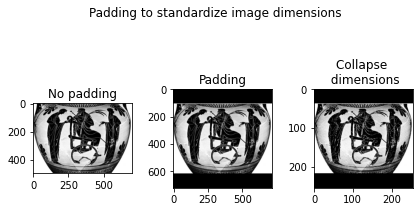

In [ ]:
# Exploratory Data Analysis for padding
dir = path + f_names[0]
image = cv2.imread(dir)
array = tf.keras.preprocessing.image.img_to_array(image) / 255
resized_img = tf.image.resize_with_pad(array,720,720) * 255
final_resize = resize_imgs(f_names[0])
fig, ax = plt.subplots(1,3)
fig.suptitle('Padding to standardize image dimensions')
fig.tight_layout()
ax[0].imshow(array)
ax[0].set_title("No padding")
ax[1].imshow(np.array(resized_img.numpy(),np.int32))
ax[1].set_title("Padding");
ax[2].imshow(np.array(final_resize.numpy(),np.int32))
ax[2].set_title("Collapse \n dimensions");

# Exploratory Data Analysis: Python

We fetched 6,696 unique images from the first 50 pages of the Arms and Armor Archives API. Due to storage and memory constraints, we worked with this initial seed list of images for the purposes of our EDA, but we plan to fetch a larger set of images downstream. Among the 6,696 images, we find that this maps to only 2,108 unique objects. This means that one museum object can have multiple images related to it. We find that the average images per ID is approximately 3.18. Thus, we can expect a single vase to be represented from different angles, crop sizes, and perspectives and we will be mindful of this later prevent leakage between our train-test splits.

In [ ]:
#dedupe columns for metadata EDA
df = df.copy()
cleaned = df.drop_duplicates(subset=['id', 'Source ID', 'Vase Number', 'Fabric', 'Technique', 'Shape Name',
       'Date', 'Attributed To', 'Decoration', 'Publication Record',
       'Pleiades URI', 'Color', 'Provenance', 'LIMC ID', 'LIMC Web',
       'CAVI Collection'],keep='first')

* We observe that multiple images are associated with a single vase. In other words, there is not a 1:1 mapping between images and vase.
* We observe that there are 3.18 images per vase.
* For the purposes of the EDA, we dedupe our metadata to understand the composition at the vase-level instead of the image-level.

In [ ]:
print("Number of rows before dedupe:",df.shape[0])
print("Number of rows after dedupe:",cleaned.shape[0])

Number of rows before dedupe: 6696
Number of rows after dedupe: 2108


''

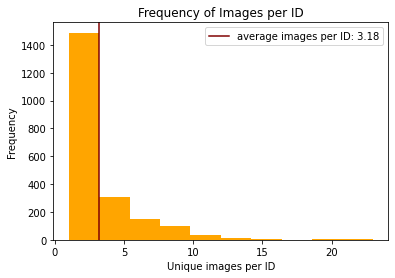

In [ ]:
# images per ID
imgs_per_id = df.groupby('id').agg({'image':'count'})
plt.hist([x for x in imgs_per_id['image']],color='orange')
plt.xlabel('Unique images per ID')
plt.ylabel('Frequency')
plt.title('Frequency of Images per ID')
mean_n = round(np.mean(imgs_per_id['image']),2)
plt.axvline(mean_n,color='maroon',label=f'average images per ID: {mean_n}')
plt.legend()
;

## EDA: One dimensional
### Technique
We examine vases by technique.
* Black-figure vases outnumber red-figure vases, with roughly 66.6\% vases are categorized as black-figure whereas 33.3\% are categorized as red figures.
* Between the 6th and 4th century B.C.E, black-figure and red-figure techniques were used in Athens to decorate fine pottery. Invented in the city of Corinth around 700 B.C.E, black-figures is the older of the two styles and features black silhouettes set against colored clay [(source)](https://www.metmuseum.org/toah/hd/vase/hd_vase.htm).
* In contrast, red-figure technique was invented around 530 B.C.E and feature red figure silhouettes on a black background. In black-figure vase painting, motifs were applied with a slip that turned black during firing.
* Instead, decorative motifs on red-figure vases remained the color of clay, inverting the background to be black. Based on this distribution of vases, the Arms and Armor collection appears to have many more black-figures.

### Date
We also examined the distribution of vases by date.
* 28\% of vases were created between 525-475 B.C.E., 21.5\% of vases were created 500-450 B.C.E, and 18.9\% of vases were made 550-500 B.C.E. The time period aligns with our understanding of when black-figure paintings (around 700 B.C.E.) and red-figure paintings that soon followed.

### Color
We also examined vases by color.
* Gray comprised 55\% of vases, black comprised 20\% of vases, and white comprised 19.5\% of vases.
* Color is different from painting style as it is possible to have a black-figure or red-figure on different colors of vases. We can think of color as a dimension that is orthogonal to painting technique. We find that the vast majority of vases were painted on gray vases, followed by white and then black. * Moreover, the ratios of colors represented are relatively stable over time, unlike other features.

### Shape
We examined shape as a dimension.
* Lekythos comprised 27.8\% of vases, Amphora, Neck comprised 8.3\% of vases, and Hydria comprised 3.9\% of vases.
* According to [the Getty Museum](https://www.getty.edu/education/teachers/classroom_resources/curricula/mythology/downloads/worksheet01_02.pdf), the Lekythos shape is characterized by a tall flask that is used to hold oil and in funeral rituals.
* The Amphora shape is characterized by two-handled storage jars that hold oil, wine, mill, or grain.
* The Hydria shape is used to carry water and typically made of bronze or pottery with three handles, two of which are used for carrying and one of which is used for pouring.
* This demonstrates that our vases are distinguished by function that dictate their shape which can may be useful features are model could learn (i.e. height of vase and/or number of handles).

### Provenace
We examined the vases based on provenance which is the place of origin or earliest known history of a vase.
* 13.7\% of vases are from Athens
* 13.2\% are from Italy, Etruria
* 8.7\% are from Greece at-large.
* We find that most of the vases are from Athens followed by regions in Italy. This is consistent with our understanding of the dataset as most of the vases we would expect to come from Greece.


### EDA (one-dimensional) - tabular count of top 5 for each dimension

In [ ]:
#understand tabular frequency of metadata
def value_counts_func(df,attribute):
  # 'Attribute to' Unique Value Count
  a_count = []
  a_values = []
  for i in (df[attribute].unique()):
      a_count.append(len(df[df[attribute]== i]))
      a_values.append(i)
  att_df = pd.DataFrame({f'{attribute}': a_values, 'Counts':a_count})
  att_df['pct'] = att_df['Counts'] / att_df['Counts'].sum()
  display(att_df.sort_values('Counts', ascending=False).head(5))

for dim in ['Technique','Shape Name','Date','Color','Provenance','Attributed To']:
  print(value_counts_func(cleaned,dim))

Technique  Counts       pct
0  BLACK-FIGURE    1404  0.666034
1    RED-FIGURE     704  0.333966

None


Shape Name  Counts       pct
29       LEKYTHOS     587  0.278463
0   AMPHORA, NECK     176  0.083491
7          HYDRIA      84  0.039848
16   CUP FRAGMENT      74  0.035104
52          CHOUS      70  0.033207

None


Date  Counts       pct
2  -525 to -475     423  0.282565
5  -500 to -450     323  0.215765
0  -550 to -500     284  0.189713
7  -575 to -525     117  0.078156
6  -475 to -425     106  0.070808

None


Color  Counts       pct
0    Grey     984  0.556561
4   Black     355  0.200792
1   White     346  0.195701
3   Brown      30  0.016968
2  Orange      18  0.010181

None


Provenance  Counts       pct
4                  ATHENS      85  0.137318
0   ITALY, ETRURIA, VULCI      82  0.132472
17           ITALY, SPINA      54  0.087237
50                 GREECE      47  0.075929
8        EGYPT, NAUCRATIS      32  0.051696

None


Attributed To  Counts       pct
124                  HAIMON P by VOS      37  0.031979
471              HAIMON P by GENIERE      28  0.024201
77                 GELA P by HASPELS      15  0.012965
267  ATHENS 581, CLASS OF by GIUDICE      14  0.012100
482  ATHENS 581, CLASS OF by GENIERE      13  0.011236

None


### EDA (one-dimensional) - Visualization of top 10 for each dimension

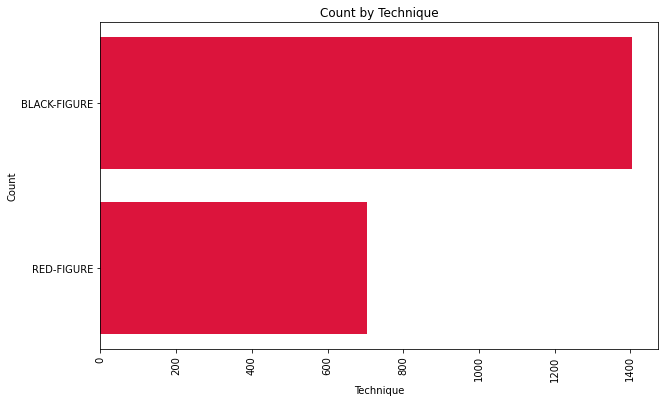

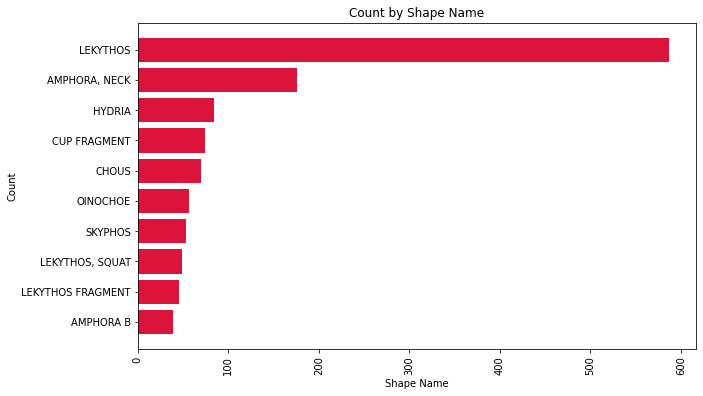

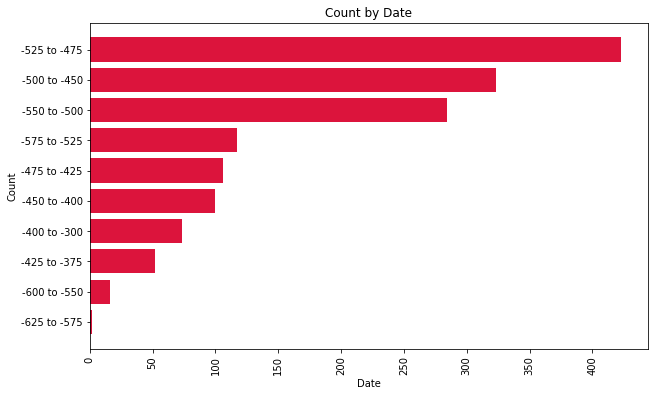

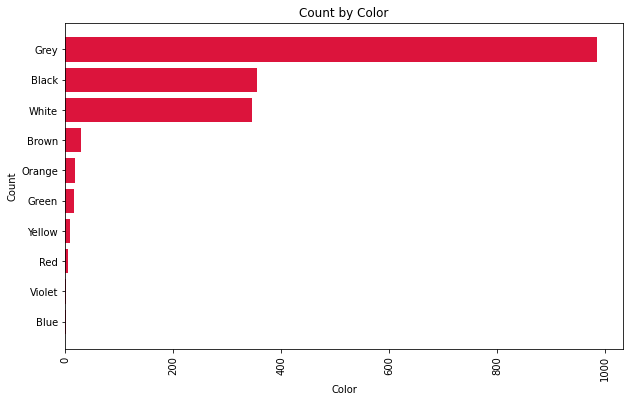

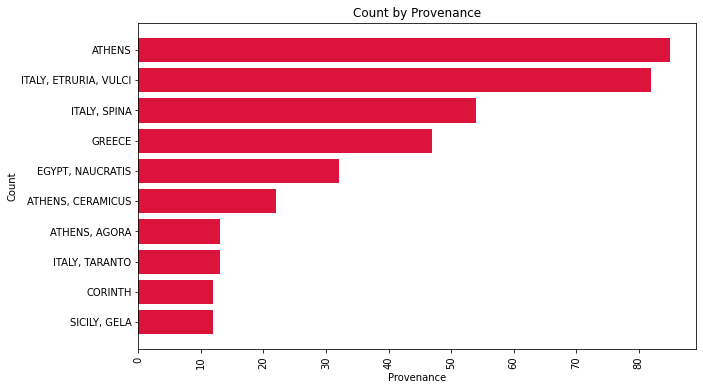

In [ ]:
from matplotlib.pyplot import figure
for i in ['Technique','Shape Name','Date','Color','Provenance']:
    figure(figsize=(10, 6))
    z = cleaned.groupby(i).agg({'id':'count'}).reset_index()
    z.rename(columns={'id':'cnt'},inplace=True)
    z = z.sort_values(by='cnt',ascending=True)
    z = z.tail(10)
    plt.barh(z[i],z['cnt'],color='crimson')
    plt.xlabel(i)
    plt.xticks(rotation=90)
    plt.ylabel('Count')
    plt.title(f'Count by {i}')
    plt.show()

# Exploratory Data Analysis: Done in R



## EDA of Meta data
Next, we moved on to examining relationships between the features in the metadata, which will later be used to improve the interpretability of our models. First, we plot the use of black-figure technique and red-figure technique over time, and observe that neither technique spans the range of dates in the collection. Black-figure technique was enormously popular during the early years of this collection of vases, but very few such vases were collected from years after 450 BC, when red-figure techniques comprised nearly the entirety of the collection. The precipitous decline in Black-technique vases after this point is due either to a historical shift, a gap in the collection, or an unrepresentative sample of the collection due to our using only the first 50 pages of results for initial EDA.

In [ ]:
# activate R magic
%load_ext rpy2.ipython

In [ ]:
r_cleaned = cleaned.copy()
r_cleaned.to_csv('r_cleaned.csv')

In [ ]:
%%R
install.packages("tidyverse")
install.packages("magrittr")

R[write to console]: Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

R[write to console]: trying URL 'https://cran.rstudio.com/src/contrib/tidyverse_1.3.1.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 702779 bytes (686 KB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[wr

In [ ]:
%%R

library(tidyverse)
library(magrittr)

R[write to console]: ── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

R[write to console]: ✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ stringr 1.4.0
✔ tidyr   1.2.0     ✔ forcats 0.5.1

R[write to console]: ── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ tidyr::extract()   masks magrittr::extract()
✖ dplyr::filter()    masks stats::filter()
✖ dplyr::lag()       masks stats::lag()
✖ purrr::set_names() masks magrittr::set_names()



In [ ]:
%%R

cleaned = read_csv('/content/r_cleaned.csv')
cleaned %<>% select(-1)

# create Country column and aggregate
cleaned <- cleaned %>%
  mutate(Country = str_extract(string = Provenance, pattern = "[A-Z]*"),
         Country = case_when(Country == "ATHENS" ~ "GREECE",
                             Country == "ATTICA" ~ "GREECE",
                             Country == "SICILY" ~ "ITALY",
                             Country == "RHODES" ~ "GREECE",
                             Country == "SATURNIA" ~ "ITALY",
                             Country == "BOEOTIA" ~ "GREECE",
                             Country == "AEGINA" ~ "GREECE",
                             Country == "CORINTH" ~ "GREECE",
                             Country == "LESBOS" ~ "GREECE",
                             Country == "MELOS" ~ "GREECE",
                             Country == "SAMOTHRACE" ~ "GREECE",
                             Country == "PHOCIS" ~ "GREECE",
                             !is.na(Country) ~ Country))

features_of_interest <- c('Technique','Shape Name','Date','Color','Provenance','Attributed To', 'Country')

# define tables and features for useful columns, for later use
table1 <- sort(table(cleaned[[features_of_interest[1]]]), decreasing = TRUE)
table2 <- sort(table(cleaned[[features_of_interest[2]]]), decreasing = TRUE)
table3 <- sort(table(cleaned[[features_of_interest[3]]]), decreasing = TRUE)
table4 <- sort(table(cleaned[[features_of_interest[4]]]), decreasing = TRUE)
table5 <- sort(table(cleaned[[features_of_interest[5]]]), decreasing = TRUE)
table6 <- sort(table(cleaned[[features_of_interest[6]]]), decreasing = TRUE)
table7 <- sort(table(cleaned[[features_of_interest[7]]]), decreasing = TRUE)


feature1 <- cleaned[[features_of_interest[1]]]
feature2 <- cleaned[[features_of_interest[2]]]
feature3 <- cleaned[[features_of_interest[3]]]
feature4 <- cleaned[[features_of_interest[4]]]
feature5 <- cleaned[[features_of_interest[5]]]
feature6 <- cleaned[[features_of_interest[6]]]
feature7 <- cleaned[[features_of_interest[7]]]

New names:
• `` -> `...1`
Rows: 2108 Columns: 20
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (16): Source ID, Fabric, Technique, Shape Name, Date, Attributed To, Dec...
dbl  (4): ...1, id, Vase Number, LIMC ID

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [ ]:
%%R

## inspect decoration column (textual description of images)

# get list of all words of three characters or more
testwords <- cleaned$Decoration %>%
  str_extract_all(., pattern = "[A-Z]{3,}") %>%
  unlist()

# plurals are a problem: for instance "SHIELD" and "SHIELDS" need to be counted
# together. To address this, we will remove the S and make all plurals singular.

# determine which words end with S
testwords_endswithS <- testwords[grepl(x = testwords, pattern = "S$")]
# remove the S
testwords_endswithS_trunc <- gsub(x = testwords_endswithS,
                                  pattern = "S$",
                                  replacement = "")

# some words that end in S are not plurals, in which case their
# truncated versions would not also be in the word list
true_plurals <- unique(testwords_endswithS_trunc[testwords_endswithS_trunc %in% testwords])
true_plurals_withS <- paste0(true_plurals, "S")

# There is a special case: WOMEN is the most common label, but is not pluralized
# using an S. So we add it manuallyto the list of plurals to replace.
true_plurals <- c(true_plurals, "WOMAN")
true_plurals_withS <- c(true_plurals_withS, "WOMEN")


In [ ]:
%%R

# now find keywords
# initialize new column
cleaned$Decoration_clean <- cleaned$Decoration

# now get all words of 3 characters or more
keywords <- cleaned$Decoration_clean %>%
  str_extract_all(., pattern = "[A-Z]{3,}")

#gsub(x = keywords[[5]],
#     pattern = true_plurals_withS[j],
#     replacement = true_plurals[j])

In [ ]:
%%R

for(i in 1:length(keywords)){
  for(j in 1:length(true_plurals)){
    # for each entry, replace plurals with their corresponding singular
    keywords[[i]] <- gsub(x = keywords[[i]],
                          pattern = true_plurals_withS[j],
                          replacement = true_plurals[j])
  }
}

In [ ]:
%%R

#keywords <- cleaned$Decoration_clean
#keywords

NULL


In [ ]:
%%R

# define list of meaningless words to be removed
meaningless_words <- c("WITH", "AND", "BETWEEN", "ONE", "BOTH",
                       "OVER","SOME", "THE", "ALL")

# flatten the keywords list into a 1-D vector, then get a table of values,
# and sort in descending order
keywords_table <- sort(table(unlist(keywords)), decreasing = T)
# filter out meaningless words
keywords_table <- keywords_table[!(names(keywords_table) %in% meaningless_words)]
# get first few common words
keywords_common <- keywords_table[1:7]
keywords_common


  WOMAN   YOUTH  DRAPED WARRIOR  SEATED CHARIOT     MAN 
    435     303     262     218     210     174     167 


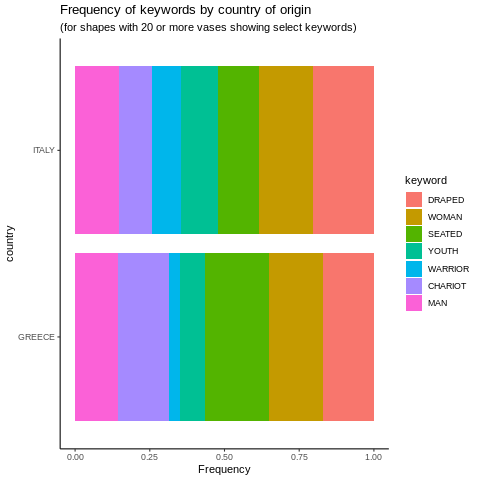

In [ ]:
%%R

# get list of potential vase colors to loop over
vase_colors <- sort(unique(feature4)[!is.na(unique(feature4))])

keywords_by_color <- list()
for(i in 1:length(vase_colors)){
  countwords <- cleaned %>%
    filter(Color == vase_colors[i]) %>%
    pluck("Decoration_clean") %>%
    unlist() %>%
    str_extract_all(pattern = "[A-Z]{3,}") %>%
    unlist() %>%
    table()
  countwords <- data.frame(countwords)
  countwords <- cbind(vase_colors[i], countwords)
  names(countwords) <- c("Color", "keyword", "Freq")
  countwords <- countwords %>%
    filter(keyword %in% names(keywords_common))
  keywords_by_color[[i]] <- countwords
}

(keywords_by_color <- keywords_by_color %>% reduce(rbind))

keywords_by_color_filtered <- keywords_by_color %>%
  # filter(Freq > 10) %>%
  group_by(Color) %>%
  mutate(Freq_sum = sum(Freq)) %>%
  filter(Freq_sum > 20)

(keywords_by_color_plot <- keywords_by_color_filtered %>%
  ggplot(data =., aes(x = Color, y = Freq, fill = keyword)) +
  geom_col(position = "fill") +
  # scale_fill_viridis_b() +
  # scale_fill_manual(values = c("black", "#E21936")) +
  coord_flip() +
  theme_classic() +
  # theme(legend.position = "none") +
  labs(title = "Frequency of keywords by color of vase",
       subtitle = "(for colors with 20 or more vases)",
       x = "Color", y = "Frequency"))

# get list of potential countries to loop over
countries <- sort(unique(feature7)[!is.na(unique(feature7))])

# initialize list
keywords_by_country <- list()
for(i in 1:length(countries)){
  # filter for vases in the current country, get words, create table
  countwords <- cleaned %>%
    filter(Country == countries[i]) %>%
    pluck("Decoration_clean") %>%
    unlist() %>%
    str_extract_all(pattern = "[A-Z]{3,}") %>%
    unlist() %>%
    table()
  # convert to dataframe, add country identifier for rowbinding later
  countwords <- data.frame(countwords)
  countwords <- cbind(countries[i], countwords)
  # set names of this dataframe
  names(countwords) <- c("country", "keyword", "Freq")
  countwords <- countwords %>%
    filter(keyword %in% names(keywords_common))
  keywords_by_country[[i]] <- countwords
}

# rowbind the individual dataframes which correspond to each country
keywords_by_country <- keywords_by_country %>% reduce(rbind)

# filter for countries with more than 20 vases
keywords_by_country_filtered <- keywords_by_country %>%
  # filter(Freq > 10) %>%
  group_by(country) %>%
  mutate(Freq_sum = sum(Freq)) %>%
  filter(Freq_sum > 20)

# plot it!
(keywords_by_country_plot <- keywords_by_country_filtered %>%
    ggplot(data =., aes(x = country, y = Freq, fill = keyword)) +
    geom_col(position = "fill") +
    # scale_fill_viridis_b() +
    # scale_fill_manual(values = c("black", "#E21936")) +
    coord_flip() +
    theme_classic() +
    # theme(legend.position = "none") +
    labs(title = "Frequency of keywords by country of origin",
         subtitle = "(for shapes with 20 or more vases showing select keywords)",
         x = "country", y = "Frequency"))


In [ ]:
%%R

# get list of top words for Italian vases, then for Greek vases
keywords_italy <- cleaned %>%
  filter(Country == "ITALY") %>%
  pluck("Decoration_clean") %>%
  str_extract_all(., pattern = "[A-Z]{3,}")

meaningless_words <- c("WITH", "AND", "BETWEEN", "ONE", "BOTH",
                       "OVER","SOME", "THE", "ALL")

keywords_italy_table <- sort(table(unlist(keywords_italy)), decreasing = T)
keywords_italy_table <- keywords_italy_table[!(names(keywords_italy_table) %in% meaningless_words)]
(keywords_italy_common <- keywords_italy_table[1:7])



  DRAPED    WOMAN DIONYSOS      MAN HERAKLES   SEATED   SHIELD 
      42       37       31       30       28       28       27 


In [ ]:
%%R

keywords_greece <- cleaned %>%
  filter(Country == "GREECE") %>%
  pluck("Decoration_clean") %>%
  str_extract_all(., pattern = "[A-Z]{3,}")

meaningless_words <- c("WITH", "AND", "BETWEEN", "ONE", "BOTH",
                       "OVER","SOME", "THE", "ALL")

keywords_greece_table <- sort(table(unlist(keywords_greece)), decreasing = T)
keywords_greece_table <- keywords_greece_table[!(names(keywords_greece_table) %in% meaningless_words)]
(keywords_greece_common <- keywords_greece_table[1:7])



   WOMEN   SEATED    WOMAN  CHARIOT   DRAPED      MAN FUNERARY 
      49       44       38       35       35       30       21 


## ggplot2 visualizations of two-dimensional data

### Country vs. Time
* Another notable shift in the dataset can be seen by considering the country of origin of older pieces in the collection as opposed to newer pieces. Italy and Greece comprise the vast majority of sources for the vases, but Italian vases were collected much earlier than Greek vases, overlapping mostly during only an estimated window of 75 years. Because this pattern is similar to that of the black-/red-technique divide, it is reasonable to question if technique is indicative of country of origin.

### Country vs. Technique
* The country vs. technique graph shows that the ratio of black to red techniques varies widely by country, and should not be assumed to be constant across space or time. Black-figure technique is much more common among Italian and Egyptian vases in the collection than Greek vases.

### Shape vs. Technique
* One of the strongest indicators of technique is the specific shape of each vase. Among common shapes (20 or more vases in the sample), we observe a distribution of ratios, from the Olpe vase (exclusively painted with black-figure technique) to the Krater Bell vase (exclusively painted with red-figure technique) to many in-between. As both Olpe and Krater vases have a distinctive, classic shape, this relationship could inform the visual recognition of other correlated features. However, among most of the colors used on vases in the collection, the ratio of black- to red-figure technique roughly approximates the 2-to-1 share of the larger dataset, indicating that the color used is not likely to be one of the most important aspects of the visual appearance of vases for classification purposes. As a result, we may be able to perform classification reasonably well using a single-channel image, enhancing the efficiency of our model.

### Meta data
* The final aspect of the metadata which proves useful for EDA is the textual description of each piece. Roughly 90\% of images have some sort of text description, and after preprocessing we can see that the seven most commonly used (meaningful) words in the descriptions are WOMAN, YOUTH, DRAPED, WARRIOR, SEATED, CHARIOT, and MAN. However, these patterns of common words do vary across other features like color and country of origin. While four of the seven most common words are shared among Greek and Italian scenes (WOMAN, DRAPED, YOUTH, and MAN), the words WARRIOR, DIONYSOS, and HERAKLES are much more common among Italian vases than Greek vases. Similarly, the words SEATED and CHARIOT are more common among Greek vases than Italian vases. The word FUNERARY appears on 21 different Greek vases, and is not used to describe any Italian vases.

### Take-away:
* These cross-feature relationships will be used to guide our choice in network architecture when building a CNN for classification of new vases, as well as improve the interpretability of the model.

## ggplot2 code

In [ ]:
%%R

### BIG PLOTTING CELLS

# naming convention: 'x12' means we are plotting the crosstabulation ('x') of
# feature1 and feature 2 from the 'features_of_interest' vector

x12 <- table(feature1, feature2)
# class(x12)
x12 <- as_tibble(as.data.frame(x12))
x12_filtered <- x12 %>%
  filter(feature2 %in% names(table2[table2 >= 20])) %>%
  group_by(feature2) %>%
  mutate(Freq_sum = sum(Freq),
         Freq_black = Freq*(feature1=="BLACK-FIGURE"),
         pct_black = Freq_black / Freq_sum,
         pct_black = max(pct_black))

(x12_plot <- x12_filtered %>%
  ggplot(data =., aes(x = reorder(feature2, pct_black), y = Freq, fill = feature1)) +
  geom_col(position = "fill") +
  scale_fill_manual(values = c("black", "#E21936")) +
  coord_flip() +
  theme(legend.position = "none") +
  labs(title = "Frequency of Black vs Red\ntechnique for Shape Name",
       subtitle = "(for shapes with 20 or more vases)",
       x = "Shape Name", y = "Frequency"))

# black/red vs date
x13 <- table(feature1, feature3)
x13 <- as_tibble(as.data.frame(x13))
x13_filtered <- x13 %>%
  # filter(feature2 %in% names(table2[table2 >= 20])) %>%
  group_by(feature3) %>%
  mutate(Freq_sum = sum(Freq),
         Freq_black = Freq*(feature1=="BLACK-FIGURE"),
         pct_black = Freq_black / Freq_sum,
         pct_black = max(pct_black))
(x13_plot <- x13_filtered %>%
  ggplot(data =., aes(x = (feature3), y = Freq, fill = feature1)) +
  geom_col(position = "stack") +
  scale_fill_manual(values = c("black", "#E21936")) +
  coord_flip() +
  theme_classic() +
  theme(legend.position = "none") +
  labs(title = "Count of Black vs Red technique by Time Period",
       x = features_of_interest[3], y = "Count"))

# black/red vs color
x14 <- table(feature1, feature4)
# class(x12)
x14 <- as_tibble(as.data.frame(x14))
x14_filtered <- x14 %>%
  # filter(feature2 %in% names(table2[table2 >= 20])) %>%
  group_by(feature4) %>%
  mutate(Freq_sum = sum(Freq),
         Freq_black = Freq*(feature1=="BLACK-FIGURE"),
         pct_black = Freq_black / Freq_sum,
         pct_black = max(pct_black))

(x14_plot <- x14_filtered %>%
  ggplot(data =., aes(x = reorder(feature4, pct_black), y = Freq, fill = feature1)) +
  geom_col(position = "fill") +
  scale_fill_manual(values = c("black", "#E21936")) +
  coord_flip() +
  theme_classic() +
  theme(legend.position = "none") +
  labs(title = "Frequency of Black vs Red technique by Color",
       x = features_of_interest[4], y = "Frequency"))

# black/red vs provenance
x15 <- table(feature1, feature5)
# class(x15)
x15 <- as_tibble(as.data.frame(x15))
x15_filtered <- x15 %>%
  filter(feature5 %in% names(table5[table5 >= 10])) %>%
  group_by(feature5) %>%
  mutate(Freq_sum = sum(Freq),
         Freq_black = Freq*(feature1=="BLACK-FIGURE"),
         pct_black = Freq_black / Freq_sum,
         pct_black = max(pct_black))

(x15_plot <- x15_filtered %>%
  ggplot(data =., aes(x = reorder(feature5, pct_black), y = Freq, fill = feature1)) +
  geom_col(position = "fill") +
  scale_fill_manual(values = c("black", "#E21936")) +
  coord_flip() +
  theme_classic() +
  theme(legend.position = "none") +
  labs(title = "Frequency of Black vs Red\ntechnique by Provenance",
       x = features_of_interest[5], y = "Frequency"))

# black/red vs country
x17 <- table(feature1, feature7)
# class(x17)
x17 <- as_tibble(as.data.frame(x17))
x17_filtered <- x17 %>%
  # filter(feature7 %in% names(table7[table7 >= 10])) %>%
  group_by(feature7) %>%
  mutate(Freq_sum = sum(Freq),
         Freq_black = Freq*(feature1=="BLACK-FIGURE"),
         pct_black = Freq_black / Freq_sum,
         pct_black = max(pct_black))

(x17_plot <- x17_filtered %>%
  ggplot(data =., aes(x = reorder(feature7, Freq_sum), y = Freq, fill = feature1)) +
  geom_col(position = "stack") +
  scale_fill_manual(values = c("black", "#E21936")) +
  coord_flip() +
  theme_classic() +
  theme(legend.position = "none") +
  labs(title = "Count of Black vs Red technique by Country",
       x = features_of_interest[7], y = "Count"))

### Visualizing crossing features with Date

# black/red vs date
x34 <- table(feature3, feature4)
x34 <- as_tibble(as.data.frame(x34))
x34_filtered <- x34 %>%
  # filter(feature2 %in% names(table2[table2 >= 20])) %>%
  group_by(feature4)
# %>% mutate(Freq_sum = sum(Freq),
#          Freq_black = Freq*(feature1=="BLACK-FIGURE"),
#          pct_black = Freq_black / Freq_sum,
#          pct_black = max(pct_black))

(x34_plot <- x34 %>%
  ggplot(data =., aes(x = (feature3), y = Freq, fill = feature4),
         color = "black") +
  geom_col(position = "fill") +
  scale_fill_manual(values = vase_colors) +
  coord_flip() +
  # theme_classic() +
  theme(legend.position = "none") +
  labs(title = "Frequency of Colors for Time Period",
       x = features_of_interest[3], y = "Frequency"))

# date vs country
x37 <- table(feature3, feature7)
# class(x37)
x37 <- as_tibble(as.data.frame(x37))
x37_filtered <- x37 %>%
  filter(feature7 %in% names(table7[table7 >= 10]))

(x37_plot <- x37 %>%
  ggplot(data =., aes(x = feature3, y = Freq, fill = feature7)) +
  geom_col(position = "stack") +
  # scale_fill_manual(values = c("black", "#E21936")) +
  coord_flip() +
  theme_classic() +
  theme(legend.title = element_blank()) +
  labs(title = "Country of origin by date",
       x = "Date", y = "Frequency"))

plots <- list(x12_plot, x13_plot, x14_plot, x15_plot, x17_plot, x34_plot, x37_plot,
              keywords_by_color_plot, keywords_by_country_plot)


## ggplot2 output

[[1]]

[[2]]

[[3]]

[[4]]

[[5]]

[[6]]

[[7]]

[[8]]

[[9]]



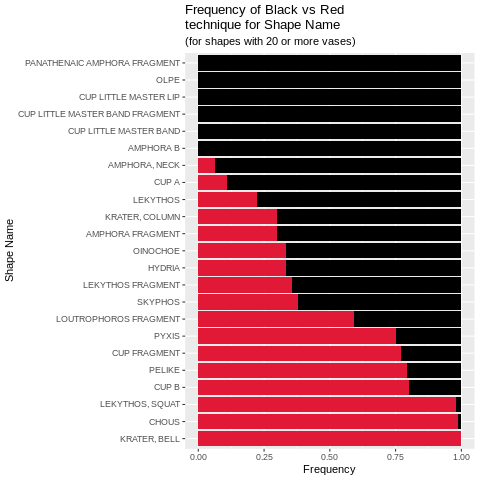

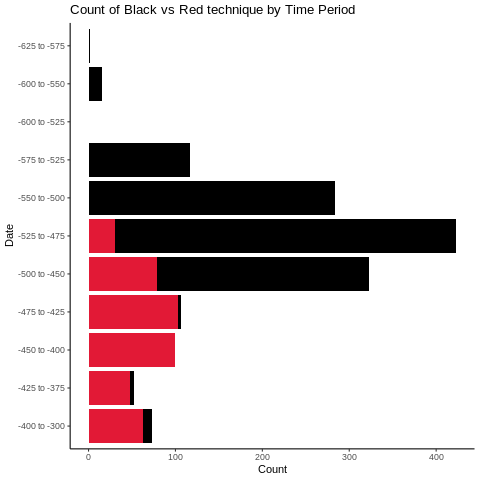

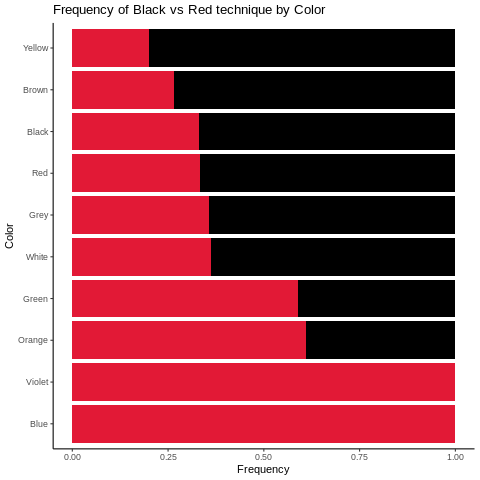

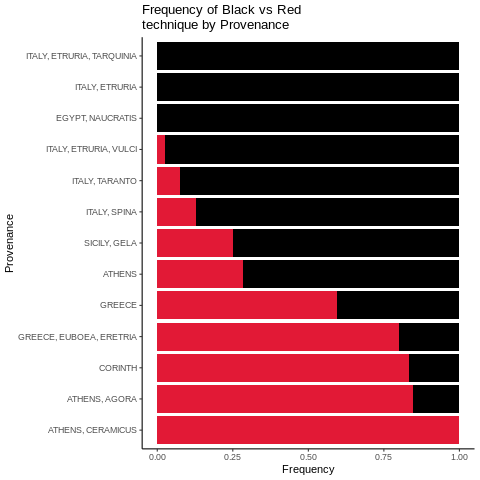

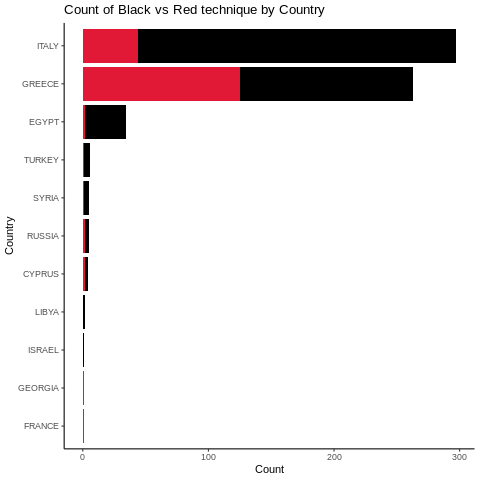

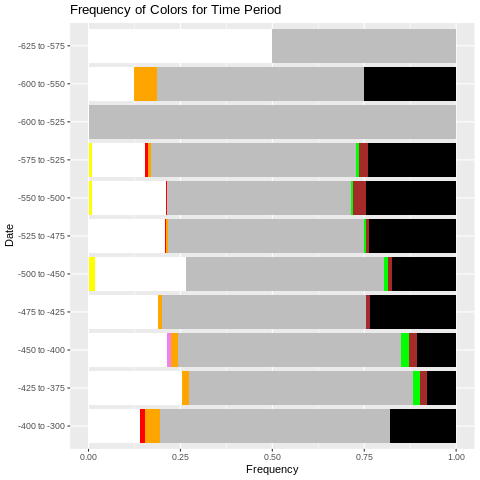

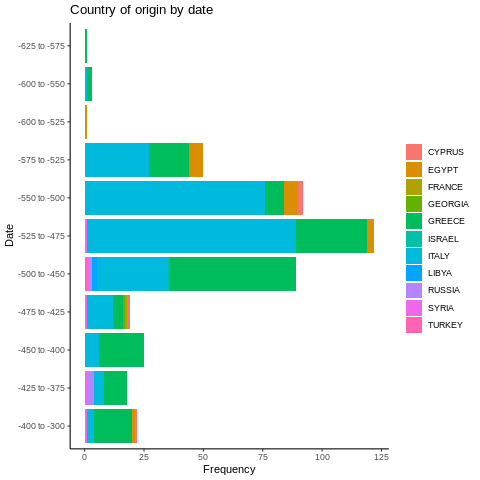

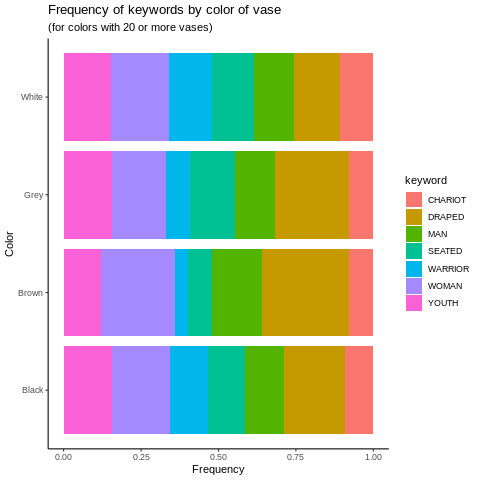

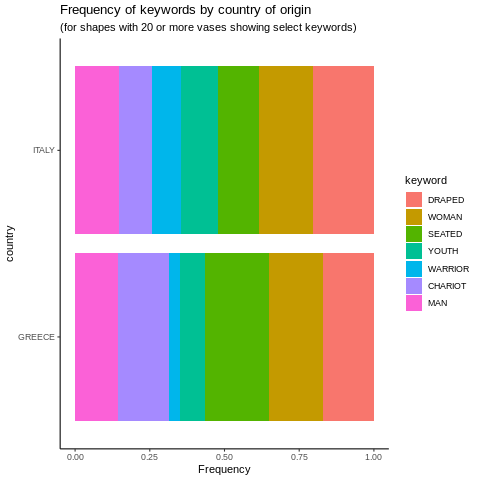

In [ ]:
%%R

# becuase we have defined plots as a list of ggplot objects, simply calling the
# list will render each plot:
plots

# Methods

* Based on our exploratory data analysis, we believe it would be most helpful to augment this textual information.

* While we are given metadata on the images via Arms and Armor API, our goal is to extract information from the images beyond the metadata. Museums currently have the power to sort images based on the text data and attributes hand-labeled by museum staff. To add value, we want to extract meaningful data from the images itself with which to sort in service of augmenting the categories already provided by the meta-data. For example, museum staff already have images labeled with "shield" and "spear". We hope to add to the list of categories. We also want a solution that can scale well with the numerous images in the catalog. We plan to do that by using a three-stage approach:

1. **Convolutional Autoencoder**: Feed input data into convolutional autoencoder to produce lower dimensional representation
2. **Unsupervised Learning:** Feed lower dimensional representation into unsupervised learning approach
3. **Vanilla CNN**: Train a follow-up convolutional neural network with the labels acquired from unsupervised learning to implement saliency maps and understand the spatial relationship of pixels that result in that K-Means label.

From this three-staged approach, we hope to recommend subset of labels that are meaningful to help museum staff better categorize Greek vases.

# Implementation

* To add value to museums, we build a model that reduces the dimensionality of images and carrying out unsupervised learning approaches such as K-Means in order to cluster images based on pixels in the image. We extract the clustering from unsupervised learning clustering to do implement saliency maps such as Grad-CAM. With Grad-CAM, we will exploit the spatial information that is preserved through the convolutional layers to understand which parts of the input image were critical to the classification decision.

* Since our goal is to find vases that belong to the same objects and scenes we are considering to implementing crop augmentation or saliency maps in order to create labels for the elements drawn within our vases.

* Further approaches include unsupervised learning approaches, namely the clustering methods of hierarchical modeling and DBSCAN. We have learned from the metadata associated with each image that hierarchies do exist (for example, Provenance to Country and Shape to “more-general-Shape”), and that correlations persist across features. We therefore expect that the visual information will reflect those distinctions, and respond well to unsupervised learning models. We predict that these clustering methods will uncover existing groups identifiable from data.

* Additionally, because the metadata are not a complete representation of the image, DBSCAN could be helpful in identifying outliers or groups of outliers, which could potentially constitute a real but unspecified grouping. Additionally, it could be useful for identifying the small number of images in the dataset which are not real images of vases, but sketches.

* DBSCAN can sometimes fail to generate meaningful clusters if the dataset is too sparse, but with many thousands of similar vases (and being photographed in mostly standardized ways). Instead, the challenge of employing unsupervised learning approaches to this task will be to ensure that the methods by which we construct groups – either through hierarchical modeling or DBSCAN – actually reflect the desired information of the vases. Examples of desired information are details in the decoration or the shapes of the ceramic, rather than quirks of photography (such as dimensions, lighting, or angle), which might instead uncover a group of images taken by the same photographer, for instance.

# Load & process images

We ran this code on JupyterHub to extract 10,000 black images.

In [ ]:
# Code in auxilary notebook
# def read_pickle_imgs(df,max_dim=720, output_dim=256):
#   image_numpy_list = []
#   image_id_list = []
#   #loops through entire dataframe
#   #df.shape[0]
#   for i in trange(0,df.shape[0]):
#     try:
#         image_filename = df['image'].iloc[i]
#         response = requests.get(image_filename)
#         img = Image.open(BytesIO(response.content))
#         np_image = np.array(img)
#         arr = tf.keras.preprocessing.image.img_to_array(np_image) / 255
#         # pad to 720
#         pad_img = tf.image.resize_with_pad(arr,max_dim,max_dim) * 255
#         # collapse everything down to 90 images by default
#         nn = tf.image.resize(pad_img, [output_dim,output_dim], method='nearest')
#         image_id_list.append(df['id'].iloc[i])
#         image_numpy_list.append(nn)
#     except:
#         pass

#   #write vector representation of images  to pickle file
#   pickled_imgs_path = 'data/pickeled_imgs_black_figure_full.pkl'
#   with open(pickled_imgs_path, 'wb') as f:
#     pickle.dump(image_numpy_list, f)

#   #write image_ids to pickle file
#   pickled_imgs_path_id = 'data/pickeled_imgs_id_black_figure_full.pkl'
#   with open(pickled_imgs_path_id, 'wb') as f:
#     pickle.dump(image_id_list, f)

# read_pickle_imgs(black_fig_df)

In [ ]:
#defines the paths to re-open file
pickled_imgs_path = path + 'data/pickeled_imgs_black_figure_full.pkl'
pickled_imgs_path_id = path + 'data/pickeled_imgs_id_black_figure_full.pkl'

#/content/drive/MyDrive/Harvard IACS/Spring 2022/AC209B: Data Science II/Final Project - Greek Vases/data/pickeled_imgs_black_figure_full.pkl
#load saved images from pickle file
with open(pickled_imgs_path , 'rb') as f:
  imgs_list = pickle.load(f)

with open(pickled_imgs_path_id , 'rb') as f:
  img_id_list = pickle.load(f)

In [ ]:
print("Verifies the images list and img_id_list is same length:",len(imgs_list),len(img_id_list))

Verifies the images list and img_id_list is same length: 9282 9282


## Ensure all images have 3 color channels
* Not all images have the same number of channels.
  * If an image has only one channel, we take that one channel and stack 3 versions of th channel to produce a cube.
  * If an image has 4 channels, we delete the 3rd dimension and concat 3x.


In [ ]:
#ensure all images have 3 color channels
added_third_dim = []
for image in imgs_list:
  # if third dimension is 1 channel, then expand to three dimensions by concating 3x
  if image.shape[2] == 1:
    z = cv2.merge((image.numpy(),image.numpy(),image.numpy()))
    added_third_dim.append(z)
   # if third dimension is 4 channel then delete 3rd dimension and concat 3x
  elif image.shape[2] == 4:
    fourth_dim = image[:,:,0]
    z = cv2.merge((fourth_dim.numpy(),fourth_dim.numpy(),fourth_dim.numpy()))
    added_third_dim.append(z)
  # if third dimension is 3 then append to image
  else:
    added_third_dim.append(image)

## Normalize + rescale images

* We normalize images such that max is 1 and min is 0.
* Normalization is helpful because it ensures that each input parameter (i.e. pixel) has a similar data distribution. This helps with faster convergence when we train the network.
* We also resize everything to 256 by 256 so that it works well with the dimension expectations of our convolutional autoencoder.


In [ ]:
# converts to 256 for handling in our modeling downstream
img_256_list = [tf.image.resize(x/255,[256,256])  for x in added_third_dim]

Max pixel value: 1.0
Min pixel value: 0.0


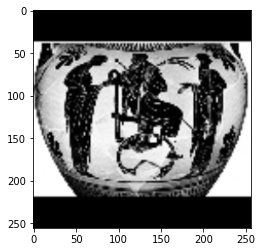

In [ ]:
#Verifies
plt.imshow(img_256_list[0])
print("Max pixel value:",np.max(img_256_list[0]))
print("Min pixel value:",np.min(img_256_list[0]))

## Preview processed images

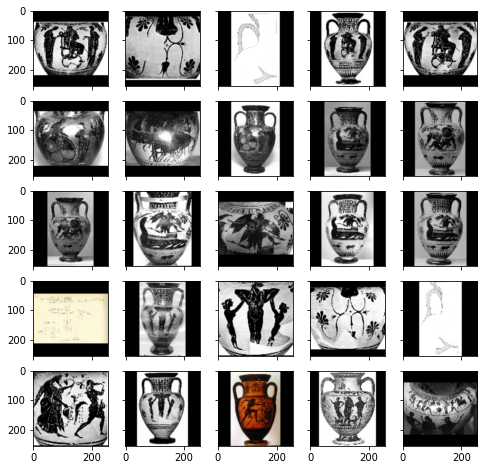

In [ ]:
fig, axs = plt.subplots(5,5,figsize=(8,8), sharex=True, sharey=True)
for i,ax in enumerate(axs.flat):
  test_img = img_256_list[i]
  ax.imshow(test_img)

# Train and test

* We want to ensure all images corresponding to the same vase are in either the train set or the test set.
* To avoid bleeding, we build a dictionary with the key as the index corresponding to the image_id and the value being the image_id. We acknowledge that a single vase may have multiple image_ids. Therefore, we must split on image_ids and not on index and we must ensure that that the vases featured in X_train do not bleed over into X_test and vice-versa.
* Given the size of the dataset, we pickle the output and reload to resolve memory issues.

In [ ]:
#create mapping between index and every image_id
idx2imgid = {x:y for (x,y) in enumerate(img_id_list)}
#create dataframe to ease filtering
df_idx2imgid = pd.DataFrame()
df_idx2imgid['idx'] = idx2imgid.keys()
df_idx2imgid['img_id'] = idx2imgid.values()

#define the set of uniqe uimage ids with which to test train split
unique_img_ids = list(set(idx2imgid.values()))

#split based on IMAGE ID, not index so that all images associated with a certain vase are on one side and not the other
X_train_imgids, X_test_imgids = train_test_split(unique_img_ids, test_size = 0.25,random_state=209)

#after we split on image id, find the correspond indexes that correspond to image_id
X_train_staging = []
X_test_staging = []
for img_id in X_train_imgids:
  z = df_idx2imgid[df_idx2imgid['img_id'] == img_id]['idx'].tolist()
  X_train_staging.append(z)
for img_id in X_test_imgids:
  z = df_idx2imgid[df_idx2imgid['img_id'] == img_id]['idx'].tolist()
  X_test_staging.append(z)

#flattened each list to produce a list of indexes
X_train_idx = [item for sublist in X_train_staging for item in sublist]
X_test_idx = [item for sublist in X_test_staging for item in sublist]

#fetch for every image at the index from above
X_train_list = [img_256_list[i] for i in X_train_idx]
X_test_list = [img_256_list[i] for i in X_test_idx]

#reshape
X_train = np.array(X_train_list).reshape(-1,256,256,3)
X_test = np.array(X_test_list).reshape(-1,256,256,3)

#save our X_train and X_test as a pickle files
pickled_X_train = path + 'data/X_train.pkl'
with open(pickled_X_train, 'wb') as f:
    pickle.dump(X_train, f,protocol=4)

pickled_X_test = path + 'data/X_test.pkl'
with open(pickled_X_test, 'wb') as f:
    pickle.dump(X_test, f,protocol=4)

pickled_X_train_idx = path + 'data/X_train_idx.pkl'
with open(pickled_X_train_idx, 'wb') as f:
    pickle.dump(X_train_idx, f,protocol=4)

pickled_X_test_idx = path + 'data/X_test_idx.pkl'
with open(pickled_X_test_idx, 'wb') as f:
    pickle.dump(X_test_idx, f,protocol=4)

# ORIGINAL CODE USED TO SPLIT - NOW DEPRECATED
# #reshapes dataset
# X = np.array((img_256_list.copy())).reshape(-1,256,256,3)
# #split into X train and Y_train
# X_train, X_test = train_test_split(X, test_size = 0.25,random_state=209)
# #splits x_train and x_test separately
# print(X_train.shape, X_test.shape)

## Reload saved train/test

We run the above code and then load from pickle files to save time.

In [ ]:
# load dictionary of index to image_id
df_idx2imgid = pickle.load(open( path + 'data/df_idx2imgid.pkl', "rb"))
# load X_train and X_test
X_train = pickle.load(open( path + 'data/X_train.pkl', "rb"))
X_test = pickle.load(open( path + 'data/X_test.pkl', "rb"))
# load X_train index
X_train_idx = pickle.load(open( path + 'data/X_train_idx.pkl', "rb"))
# load X_test index
X_test_idx = pickle.load(open( path + 'data/X_test_idx.pkl', "rb"))
# load train and test image ids
X_train_img_ids = [df_idx2imgid['img_id'].iloc[i] for i in X_train_idx]
X_test_img_ids = [df_idx2imgid['img_id'].iloc[i] for i in X_test_idx]

In [ ]:
# checks the same of them: n x 256 x 256
print(X_train.shape, X_test.shape)

(7011, 256, 256, 3) (2271, 256, 256, 3)


## Create dataset function

We write a create dataset function to allow tensorflow to batch our data in batches of 10 to ease memory load.

In [ ]:
def create_dataset(data_in):
    dataset = tf.data.Dataset.from_tensor_slices((data_in,data_in))
    dataset = dataset.shuffle(1000)
    dataset = dataset.batch(10)
    dataset = dataset.prefetch(1)
    return dataset

In [ ]:
X_train_create_ds = create_dataset(X_train)
X_test_create_ds = create_dataset(X_test)

# Model: Convolutional Autoencoder (CAE) - Stage 1





## Define & summary

* We can use a convolutional autoencoder as an unsupervised learning technique because it does not require a label and has proven useful in processing image data (i.e. feature extraction, image compression, image de-noising).
* We wanted to explore this architecture to reduce the dimensionality of our data and extracting the features.

Motivated by these papers:
1. Maggipinto, Marco, Chiara Masiero, Alessandro Beghi, and Gian Antonio Susto. “A Convolutional Autoencoder Approach for Feature Extraction in Virtual Metrology.” Procedia Manufacturing, 28th International Conference on Flexible Automation and Intelligent Manufacturing (FAIM2018), June 11-14, 2018, Columbus, OH, USAGlobal Integration of Intelligent Manufacturing and Smart Industry for Good of Humanity, 17 (January 1, 2018): 126–33. https://doi.org/10.1016/j.promfg.2018.10.023. https://www.sciencedirect.com/science/article/pii/S2351978918311399
2. Zhang, Yifei. “A Better Autoencoder for Image: Convolutional Autoencoder,” n.d., 7. http://users.cecs.anu.edu.au/~Tom.Gedeon/conf/ABCs2018/paper/ABCs2018_paper_58.pdf


In [ ]:
def conv_autoencoder():
  """ build convolutional autoencoder (CAE) model with encoder + decoder """
  # encoder
  model = Sequential(name='convolutional_autoencoder')
  model.add(Conv2D(64, kernel_size=(3, 3),activation='relu',input_shape=(256, 256, 3),padding='same', name='encoding_Conv2D_1'))
  model.add(MaxPooling2D(pool_size=(2, 2), strides=2, padding='same', name='encoding_MaxPooling2D_1'))
  model.add(Conv2D(128, kernel_size=(3, 3),strides=1,kernel_regularizer = tf.keras.regularizers.L2(0.001),activation='relu',padding='same', name='encoding_Conv2D_2'))
  model.add(MaxPooling2D(pool_size=(2, 2), strides=2, padding='same', name='encoding_MaxPooling2D_2'))
  model.add(Conv2D(256, kernel_size=(3, 3), activation='relu',kernel_regularizer= tf.keras.regularizers.L2(0.001), padding='same', name='encoding_Conv2D_3'))
  model.add(MaxPooling2D(pool_size=(2, 2), strides=2, padding='same', name='encoding_MaxPooling2D_3'))
  model.add(Conv2D(512, kernel_size=(3, 3), activation='relu',kernel_regularizer= tf.keras.regularizers.L2(0.001), padding='same', name='encoding_Conv2D_4'))
  model.add(MaxPooling2D(pool_size=(2, 2), strides=2,padding='valid', name='encoding_MaxPooling2D_4'))
  model.add(Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same', name='encoding_Conv2D_5'))
  model.add(MaxPooling2D(pool_size=(2,2), strides=2, padding='valid'))
  # decoder portion
  model.add(Conv2D(512, kernel_size=(3, 3), kernel_regularizer = tf.keras.regularizers.L2(0.001),activation='relu', padding='same', name='decoding_Conv2D_1'))
  model.add(UpSampling2D((2, 2), name='decoding_Upsamping2D_1'))
  model.add(Conv2D(512, kernel_size=(3, 3), kernel_regularizer = tf.keras.regularizers.L2(0.001), activation='relu', padding='same', name='decoding_Conv2D_2'))
  model.add(UpSampling2D((2, 2), name='decoding_Upsamping2D_2'))
  model.add(Conv2D(256, kernel_size=(3, 3), kernel_regularizer = tf.keras.regularizers.L2(0.001), activation='relu', padding='same',name='decoding_Conv2D_3'))
  model.add(UpSampling2D((2, 2),name='decoding_Upsamping2D_3'))
  model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', kernel_regularizer = tf.keras.regularizers.L2(0.001), padding='same',name='decoding_Conv2D_4'))
  model.add(UpSampling2D((2, 2),name='decoding_Upsamping2D_4'))
  model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', kernel_regularizer = tf.keras.regularizers.L2(0.001), padding='same',name='decoding_Conv2D_5'))
  model.add(UpSampling2D((2, 2),name='decoding_Upsamping2D_5'))
  model.add(Conv2D(3, kernel_size=(3, 3), padding='same',activation='sigmoid',name='decoding_Output'))
  return model

#instantiate model
model = conv_autoencoder()
model.summary()

Model: "Convolutional_AutoEncoder_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Encoding_Conv2D_1 (Conv2D)  (None, 256, 256, 64)      1792      
                                                                 
 Encoding_MaxPooling2D_1 (Ma  (None, 128, 128, 64)     0         
 xPooling2D)                                                     
                                                                 
 Encoding_Conv2D_2 (Conv2D)  (None, 128, 128, 128)     73856     
                                                                 
 Encoding_MaxPooling2D_2 (Ma  (None, 64, 64, 128)      0         
 xPooling2D)                                                     
                                                                 
 Encoding_Conv2D_3 (Conv2D)  (None, 64, 64, 256)       295168    
                                                                 
 Encoding_MaxPooling2D_3 (Ma  (None

## CAE: Hyperparameters
* Loss: We choose loss of MSE. This will minimize the loss between the input and the output (since a CAE's goal is to reproduce the input). The lower the loss, the better. Since we normalized the data such that the pixel values are between 0 and 1,  MSE is ultimately a better metric because our values are continuous.
* Optimizer: We decide on Adam optimizer which uses Adaptive Momentum estimation which computes adaptive learning rates for each parameters.
* Metric: We choose accuracy as our metric.

In [ ]:
# compile model
model.compile(loss='mse',optimizer='adam',metrics=['accuracy'])

#define earlier stopping + checkpoints
early_stopping = EarlyStopping(monitor='val_loss', mode='min',verbose=1,patience=6,min_delta=0.001)
checkpoint = ModelCheckpoint('/content/drive/MyDrive/Harvard IACS/Spring 2022/AC209B: Data Science II/Final Project - Greek Vases/normalized_black_figure_full.h5', monitor='val_loss', mode='min', save_best_only=True)

#train model
history = model.fit(X_train_create_ds, validation_data=X_test_create_ds,epochs=10, callbacks=[early_stopping,checkpoint])

#save model history to dataframe
hist_df = pd.DataFrame(history.history)

# save model history dataframe to csv:
hist_csv_file = path+ 'normalized_black_figure_full_history.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

#save model to directory for later use
model_save_dir = path + 'normalized_black_figure_full_model.h5'
model.save(model_save_dir)

Epoch 1/10
702/702 [==============================] - 1401s 2s/step - loss: 0.0818 - accuracy: 0.6072 - val_loss: 0.0323 - val_accuracy: 0.8571
Epoch 2/10
702/702 [==============================] - 1421s 2s/step - loss: 0.0266 - accuracy: 0.7609 - val_loss: 0.0235 - val_accuracy: 0.9632
Epoch 3/10
702/702 [==============================] - 1441s 2s/step - loss: 0.0236 - accuracy: 0.6725 - val_loss: 0.0215 - val_accuracy: 0.4745
Epoch 4/10
702/702 [==============================] - 1414s 2s/step - loss: 0.0224 - accuracy: 0.7250 - val_loss: 0.0212 - val_accuracy: 0.9250
Epoch 5/10
702/702 [==============================] - 1394s 2s/step - loss: 0.0209 - accuracy: 0.8223 - val_loss: 0.0245 - val_accuracy: 0.9721
Epoch 6/10
702/702 [==============================] - 1401s 2s/step - loss: 0.0201 - accuracy: 0.8503 - val_loss: 0.0235 - val_accuracy: 0.8825
Epoch 7/10
702/702 [==============================] - 1391s 2s/step - loss: 0.0196 - accuracy: 0.8341 - val_loss: 0.0186 - val_accuracy:

## CAE Results

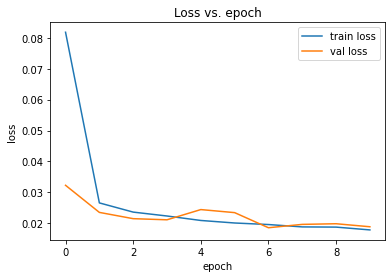

In [ ]:
plt.plot(history.history['loss'],label='train loss')
plt.plot(history.history['val_loss'],label='val loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss vs. epoch')
plt.legend();

## Reload Convolutional Autoencoder model

In [ ]:
model = keras.models.load_model(path + 'normalized_black_figure_full_model.h5')

## CAE: Feature extraction at different layers
* We are experiment with max pooling vs. average pooling across the feature maps when extracting the output of different layers.
* Max pooling will pick out the most salient features across the feature maps whereas average pooling will take the mean across the feature maps.
* We ultimately select max pooling as our default because we want to feed into our K-means model the most salient/prominent features from the CAE. Average pooling could blur the extreme values in a way that would make it challenging for K-means to distinguish vases.  


In [ ]:
def feature_extraction(model, data, layer = 10, pool_type = 'max'):
    """
    extract features from any given layer in the model
    model - convolutional autoencoder from that we trained
    data - set of images with which to get extract layer
    layer - index of the layer we want to extract
    """
    # feed in the input and extract layer[index]
    encoded = K.function([model.layers[0].input],[model.layers[layer].output])
    # extract the data
    encoded_array = encoded([data])[0]
    # carry out max pooling
    if pool_type == 'max':
      return encoded_array.max(axis=-1)
    # carry out average pooling
    if pool_type == 'avg':
      return encoded_array.mean(axis=-1)

In [ ]:
# Confirms output of each layer
for layer in trange(0,21):
  print("Layer {}:".format(layer), feature_extraction(model,X_test[0:3],layer, pool_type='max').shape)

  0%|          | 0/21 [00:00<?, ?it/s]

Layer 0: (3, 256, 256)
Layer 1: (3, 128, 128)
Layer 2: (3, 128, 128)
Layer 3: (3, 64, 64)
Layer 4: (3, 64, 64)
Layer 5: (3, 32, 32)
Layer 6: (3, 32, 32)
Layer 7: (3, 16, 16)
Layer 8: (3, 16, 16)
Layer 9: (3, 8, 8)
Layer 10: (3, 8, 8)
Layer 11: (3, 16, 16)
Layer 12: (3, 16, 16)
Layer 13: (3, 32, 32)
Layer 14: (3, 32, 32)
Layer 15: (3, 64, 64)
Layer 16: (3, 64, 64)
Layer 17: (3, 128, 128)
Layer 18: (3, 128, 128)
Layer 19: (3, 256, 256)
Layer 20: (3, 256, 256)


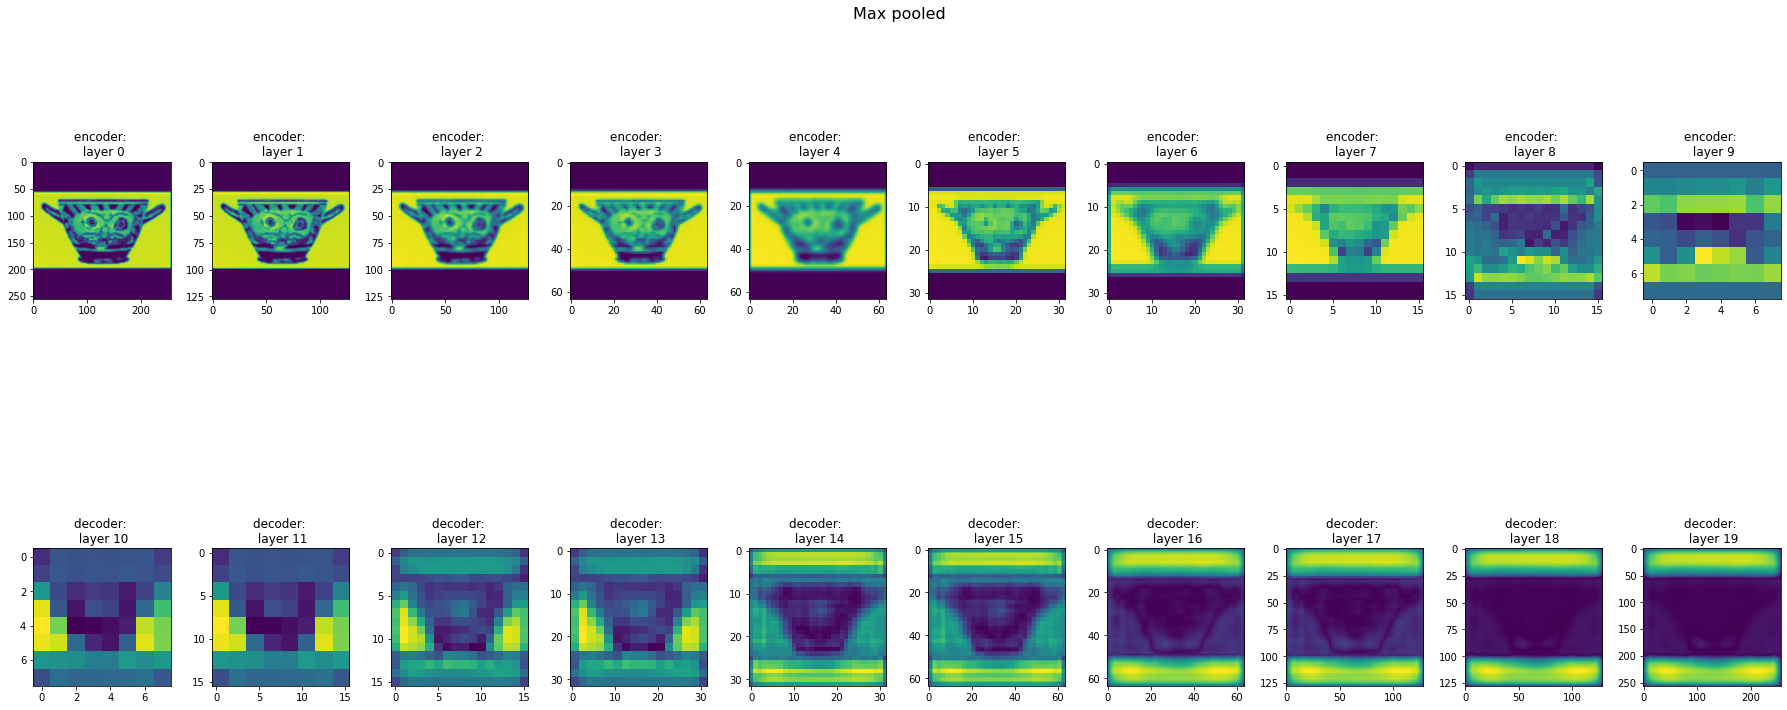

In [ ]:
# MAX POOL
fig, axs = plt.subplots(2,10,figsize=(25,12))
fig.tight_layout(rect=[0, 0.03, 1, 0.95], h_pad=0.01)
fig.suptitle('Max pooled', fontsize=16)
for layer_index,ax in enumerate(axs.flat):
  encoded = feature_extraction(model,X_train[0:3],layer_index, pool_type='max')
  ax.imshow(encoded[0,:,:])
  if layer_index > 9:
    ax.set_title(f'decoder: \n layer {layer_index}')
  else:
    ax.set_title(f'encoder: \n layer {layer_index}')

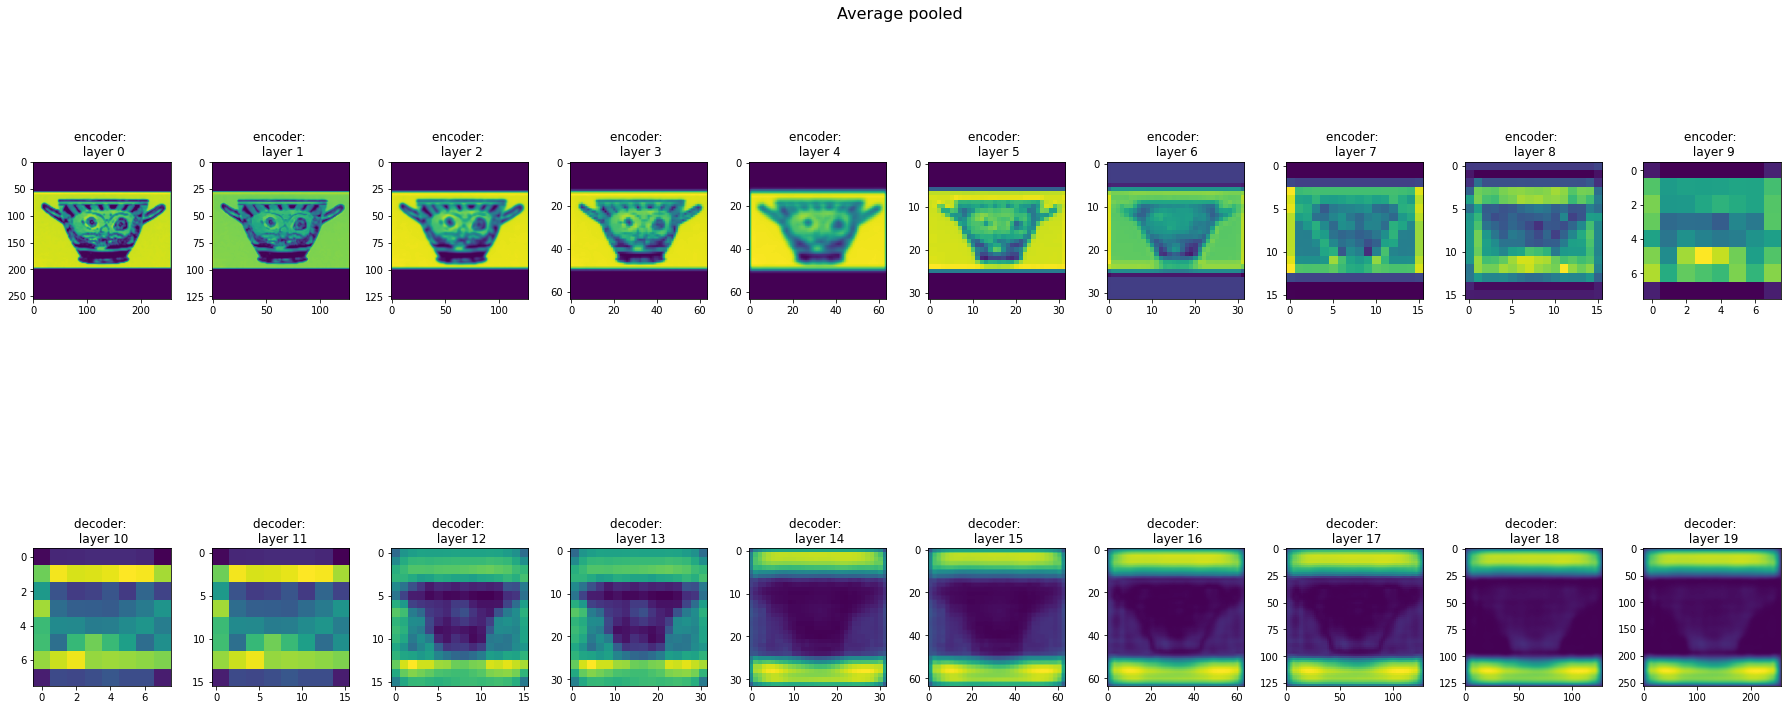

In [ ]:
#AVERAGE POOL
fig, axs = plt.subplots(2,10,figsize=(25,12))
fig.tight_layout(rect=[0, 0.03, 1, 0.95], h_pad=0.01)
fig.suptitle('Average pooled', fontsize=16)
for layer_index,ax in enumerate(axs.flat):
  encoded = feature_extraction(model,X_train[0:3],layer_index, pool_type='avg')
  ax.imshow(encoded[0,:,:])
  if layer_index > 9:
    ax.set_title(f'decoder: \n layer {layer_index}')
  else:
    ax.set_title(f'encoder: \n layer {layer_index}')

# Model: K-means - Stage 2

* We cluster on the feature representations extracted at different layers of the convolutational autoencoder.
* We focus on clustering at the feature representation from the model output at layer 6 after max pooling because the dimensionality is small (30x30).
* We focus on clustering at the feature representation from the model output at layer at layer 10 which is the smallest latent representation of our image because it is after all the encoder steps of our model (8x8).
* We justify these two choices because we want to explore the trade-off between a larger image with more information (30x30) vs. a smaller image with potentially less information (8x8).

## K-means: Model layer output = 6

In [ ]:
def get_batches(data, batch_size=64):
    """ batches images for extraction """
    # if the length of the dataframe is smaller tahn the batch, return data as is
    if len(data) < batch_size:
        return [data]
    # define the number of batches as the length of df divided by batch size
    n_batches = len(data) // batch_size
    # If batches fit exactly into the size of df.
    if len(data) % batch_size == 0:
        return [data[i*batch_size:(i+1)*batch_size] for i in range(n_batches)]
    # If there is a remainder.
    else:
        return [data[i*batch_size:min((i+1)*batch_size, len(data))] for i in range(n_batches+1)]

* We iterate through our test set and extract the output of feeding each image in our test set corresponding to layer at index 6 in our CAE.

In [ ]:
X_encoded = []
# Iterate through the full test set.
for batch in get_batches(X_test, batch_size=100):
    # Pooling function on the model for each batch within test set for model output 6
    X_encoded.append(feature_extraction(model,batch,6))
#concat all items in list into a numpy array
X_encoded = np.concatenate(X_encoded)
#reshape to ravel the second two dimensions of the features
X_encoded_reshape = X_encoded.reshape(X_encoded.shape[0], X_encoded.shape[1]*X_encoded.shape[2])
# print to confirm the ravel worked
print(X_encoded_reshape.shape)

(2271, 1024)


#### Results: Elbow method for feature representations for layer 6 of CAE
We employ the elbow method heuristic to choose an appropriate K. By plotting the SSE as a function of $K$ clusters, we select the elbow of the curve as the number of clusters to use. We choose a point where the diminishing improvements to SSE are no longer worth the cost.

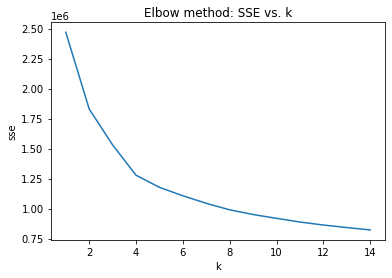

In [ ]:
sse = []
k_list = range(1, 15)
for k in k_list:
    km = KMeans(n_clusters=k)
    km.fit(X_encoded_reshape)
    sse.append(km.inertia_)

plt.plot(k_list,sse)
plt.title("Elbow method: SSE vs. k")
plt.xlabel('k')
plt.ylabel('sse')
plt.show();

### Results: Visualize clusters from layer 6 output: t-SNE and PCA
* PCA is a unsupervised linear dimensionality reduction and data visualization technique for high dimensionaliy data.
* t-SNE stands for t-disributed stochastic neighborhood embedding and it is also an unsupervised technique, but it carries out non-linear dimensionality reduction also for high-dimensionality data.
* The idea is that t-SNE embeds points from a higher dimension to a lower dimension while trying to preserve the neighborhood of that point. More specifically, t-SNE preserves the local structure of data by minimizing the KL divergence between two distributions with respect to the locations of the points on the map.
* We wanted to visualizations the clusters in both types of representations to understand the strength of our clustering.
* We noticed that the pattern of clusters in t-SNE for features from layer 6 are a lot more distinct from the the equivalent for layer 10.

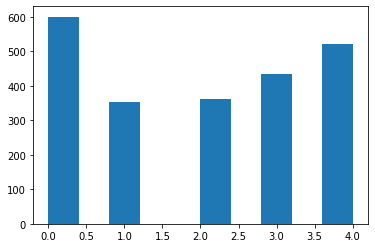

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


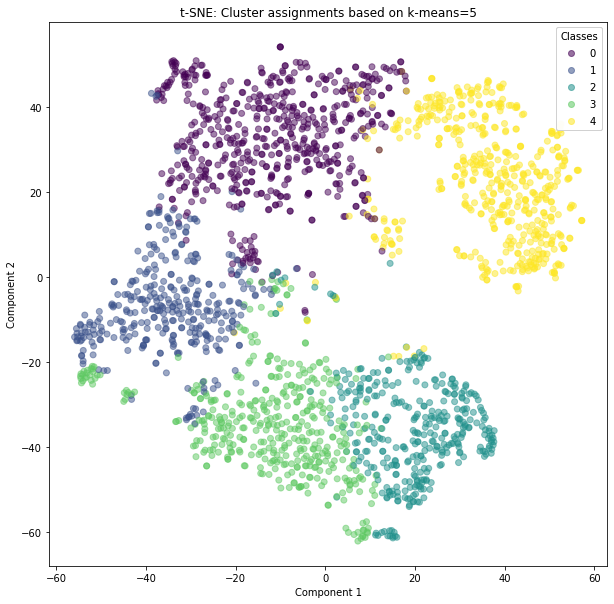

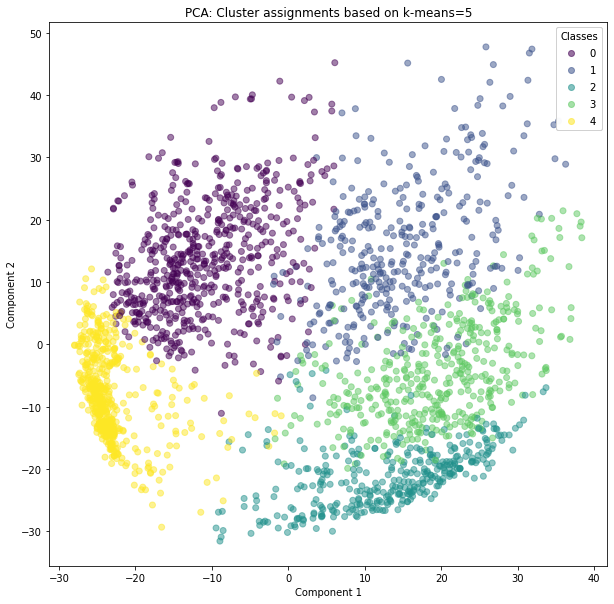

In [ ]:
#defines the number of clusters
n_clusters_ = 5

#k_-means
kmeans = KMeans(n_clusters = n_clusters_, random_state=209).fit(X_encoded_reshape)
labels=kmeans.labels_
plt.hist(labels)
plt.show();

# t-SNE
transform = TSNE
trans = transform(n_components=2)
values = trans.fit_transform(X_encoded_reshape)
tsne_1 = [x[0] for x in values]
tsne_2 = [x[1] for x in values]
# PCA
pca = PCA(n_components=2)
pca_results = pca.fit_transform(X_encoded_reshape)
pca_1 = [x[0] for x in pca_results]
pca_2 = [x[1] for x in pca_results]


## TSNE
fig, ax = plt.subplots(figsize=(10,10))
scatter = ax.scatter(tsne_1,tsne_2,c=labels, alpha=0.5)
ax.set_title("t-SNE: Cluster assignments based on k-means={}".format(n_clusters_))
ax.set_xlabel("Component 1")
ax.set_ylabel("Component 2")
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper right", title="Classes")
ax.add_artist(legend1)
plt.show();

## PCA
fig, ax = plt.subplots(figsize=(10,10))
scatter = ax.scatter(pca_1,pca_2,c=labels, alpha=0.5)
ax.set_title("PCA: Cluster assignments based on k-means={}".format(n_clusters_))
ax.set_xlabel("Component 1")
ax.set_ylabel("Component 2")
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper right", title="Classes")
ax.add_artist(legend1)
plt.show()

In [ ]:
def display_images_kmeans_label(X_test,labels, class_label):
  index_label = np.where(labels == class_label)
  print("Number of images with class {}:".format(class_label),len(index_label[0]))
  fig, axs = plt.subplots(5,5,figsize=(8,8), sharex=True, sharey=True)
  fig.tight_layout(rect=[0, 0.03, 1, 0.95])
  fig.suptitle("Images associated with class {}".format(class_label))
  for i,ax in enumerate(axs.flat):
    test_img = X_test[index_label][i]
    ax.imshow(test_img)

<a name="layer-6-output"></a>
### Results: Visualize clusters as a sanity check
* Class 0 appears to be a combination of urns with two handles and/or fragments.
* Class 1 appears to be a mix of circular objects and and close-ups.
* Class 2 apepars to be larger wide saucers and cups.
* Class 3 appears to be vases with images taken from the bottom and/or more trapezoid in shape.
* Class 4 appears to be larger tall, skinny urns. This class seems like the most homogenous followed by class 2.
* This also aligns with what we see in the t-SNE and PCA plots as class 2 and class 4 are more distinctly isolated from the other clusters.  

  0%|          | 0/5 [00:00<?, ?it/s]

Number of images with class 0: 600
Number of images with class 1: 354
Number of images with class 2: 363
Number of images with class 3: 433
Number of images with class 4: 521


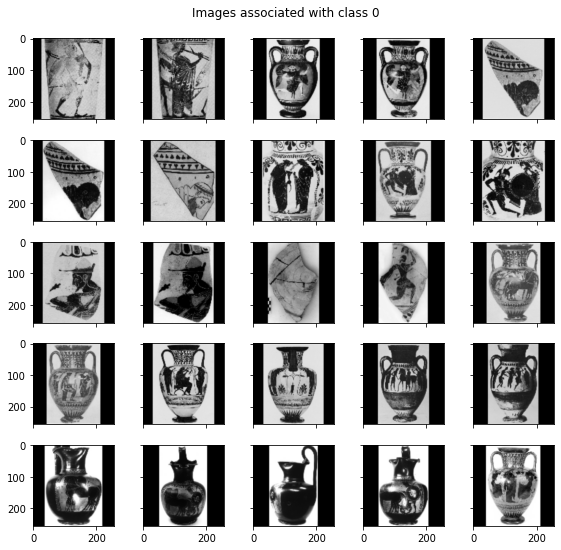

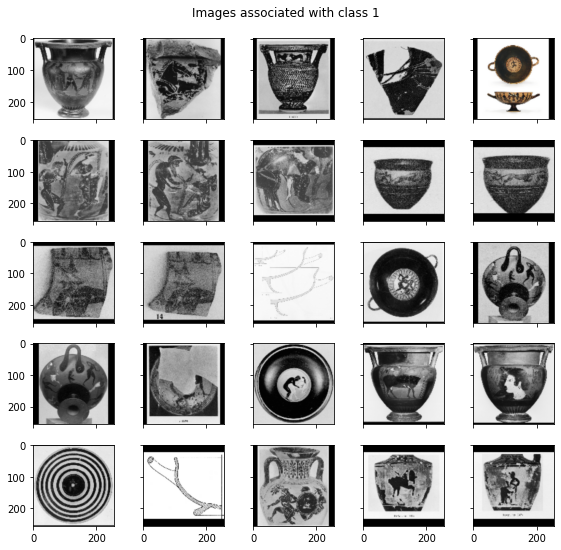

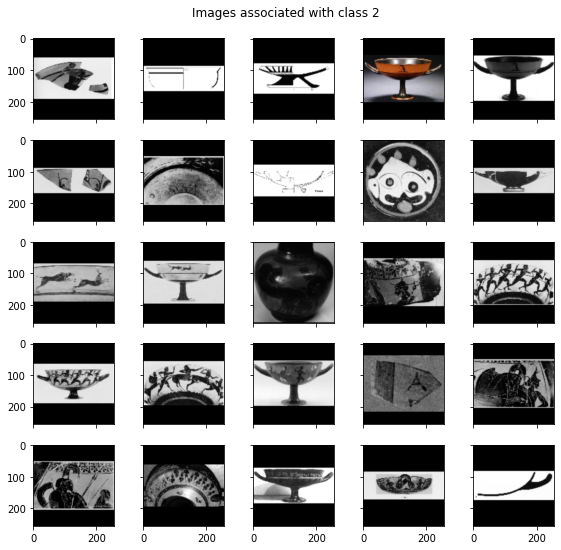

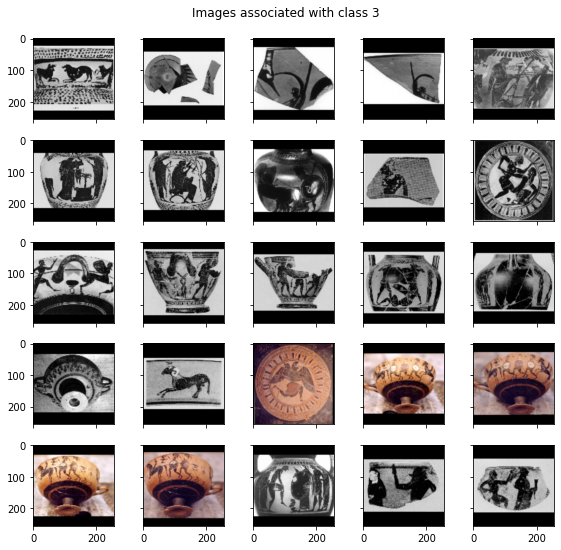

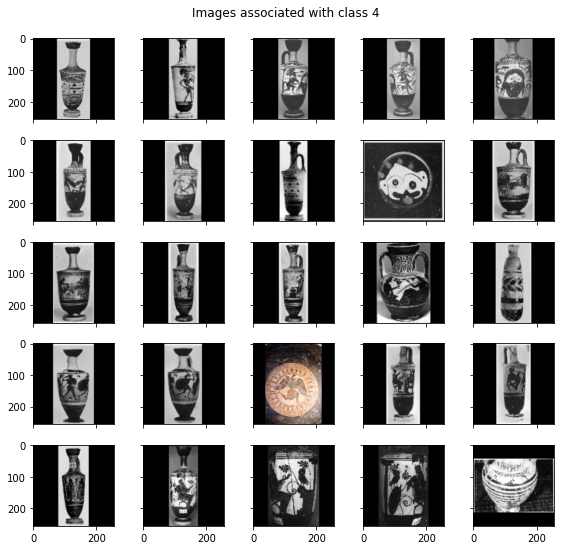

In [ ]:
for k in trange(n_clusters_):
  display_images_kmeans_label(X_test,labels,k);

## K-means: Model layer output = 10
We repeat the same procedure but for the features extracted of layer 10 of our convolutional autoencoder.

In [ ]:
X_encoded = []
for batch in get_batches(X_test, batch_size=100):
    X_encoded.append(feature_extraction(model,batch,10))
X_encoded = np.concatenate(X_encoded)
X_encoded_reshape = X_encoded.reshape(X_encoded.shape[0], X_encoded.shape[1]*X_encoded.shape[2])
print(X_encoded_reshape.shape)

(2271, 64)


Based on this SSE/inertia vs. K plot, we select the optimal K as 4.

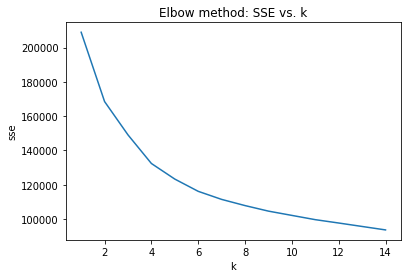

In [ ]:
sse = []
k_list = range(1, 15)
for k in k_list:
    km = KMeans(n_clusters=k)
    km.fit(X_encoded_reshape)
    sse.append(km.inertia_)

plt.plot(k_list,sse)
plt.title("Elbow method: SSE vs. k")
plt.xlabel('k')
plt.ylabel('sse')
plt.show();

### Results: Visualize clusters from layer 10 output: t-SNE vs. PCA
* When we visualize clusters from from the features extracted at layer 10, we see that there is significantly more overlap in the clusters for both t-SNE and PCA. For example, the clusters assigned to class 0 are isolated in the bottom left of the t-SNE plot but there are also poitns classified as class 0 embedded within the other clusters. Furthermore, the PCA plots also shows significantly more overlap.
* These results make sense because the dimension of the features extracted at layer 10 of our CAE is only 8x8. This smaller representation has less information compared to the larger feature representation (30x30).

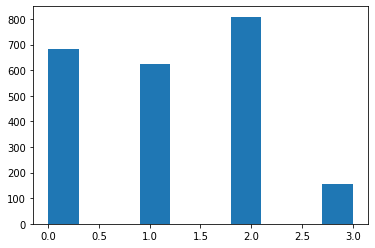

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


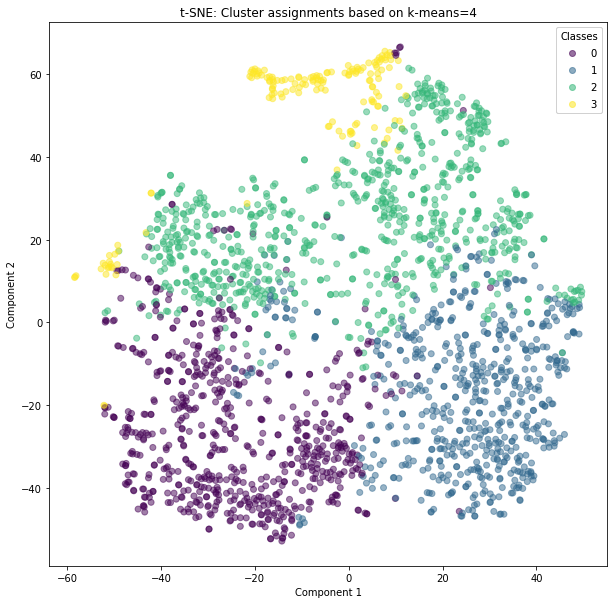

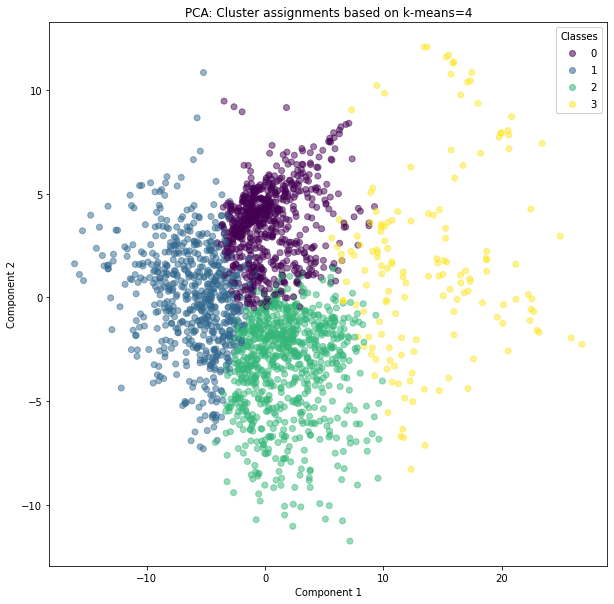

In [ ]:
#defines the number of clusters
n_clusters_ = 4

#k_-means
kmeans = KMeans(n_clusters = n_clusters_, random_state=209).fit(X_encoded_reshape)
labels=kmeans.labels_
plt.hist(labels)
plt.show();

# t-SNE
transform = TSNE
trans = transform(n_components=2)
values = trans.fit_transform(X_encoded_reshape)
tsne_1 = [x[0] for x in values]
tsne_2 = [x[1] for x in values]
# PCA
pca = PCA(n_components=2)
pca_results = pca.fit_transform(X_encoded_reshape)
pca_1 = [x[0] for x in pca_results]
pca_2 = [x[1] for x in pca_results]

### PLOTTING ###
# TSNE
fig, ax = plt.subplots(figsize=(10,10))
scatter = ax.scatter(tsne_1,tsne_2,c=labels, alpha=0.5)
ax.set_title("t-SNE: Cluster assignments based on k-means={}".format(n_clusters_))
ax.set_xlabel("Component 1")
ax.set_ylabel("Component 2")
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper right", title="Classes")
ax.add_artist(legend1)
plt.show();

# PCA
fig, ax = plt.subplots(figsize=(10,10))
scatter = ax.scatter(pca_1,pca_2,c=labels, alpha=0.5)
ax.set_title("PCA: Cluster assignments based on k-means={}".format(n_clusters_))
ax.set_xlabel("Component 1")
ax.set_ylabel("Component 2")
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper right", title="Classes")
ax.add_artist(legend1)
plt.show()

### Visualize clusters as sanity check
**Interpretation:**
* Class 0: It represents a mix of shards and skinny jars.
* Class 1: This class has jars with multiple people.
* Class 2: This class represents a mix of different jars.
* Class 3: This class looks like mostly sketches.

  0%|          | 0/4 [00:00<?, ?it/s]

Number of images with class 0: 681
Number of images with class 1: 625
Number of images with class 2: 809
Number of images with class 3: 156


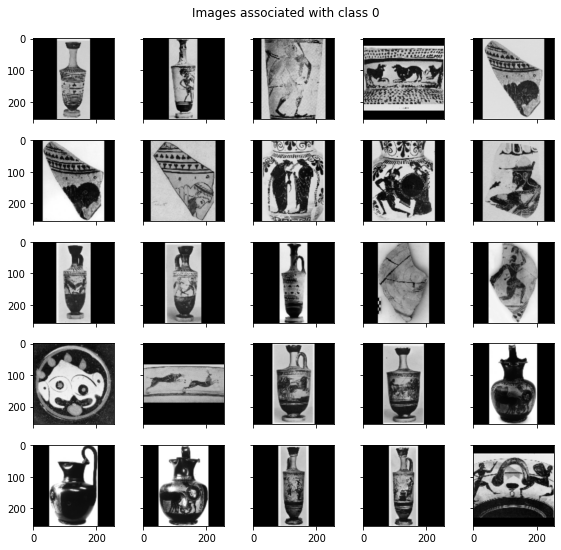

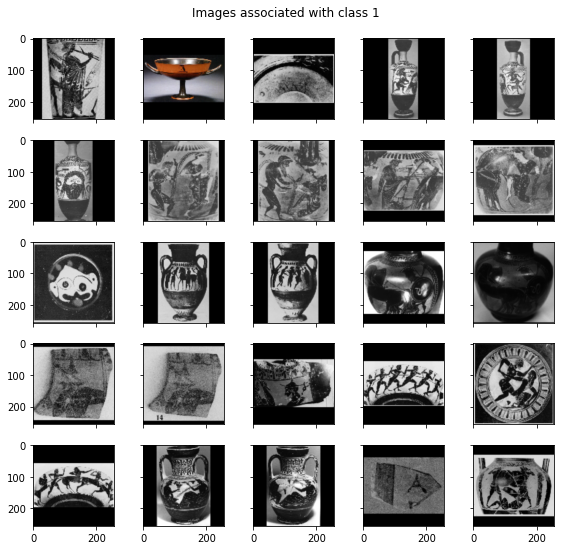

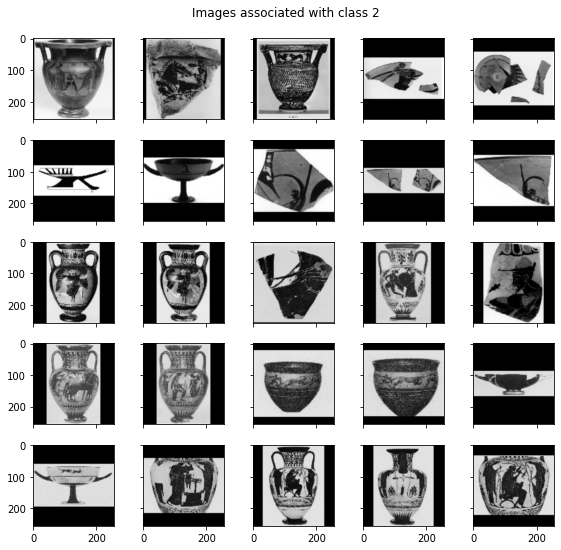

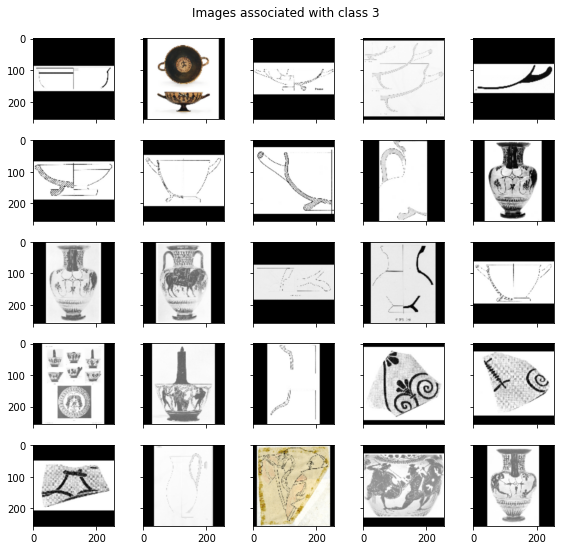

In [ ]:
for k in trange(n_clusters_):
  display_images_kmeans_label(X_test,labels,k);

## Quantifying cluster composition by checking with metadata (layer index 6)
*  Each vase can have multiple image ids.
* Therefore, we take the mode of the predictions across all images for each vase to help with understanding the output of each cluster.

In [ ]:
kmeans_layer_6 = pd.DataFrame()
kmeans_layer_6['img_id'] = X_test_img_ids
kmeans_layer_6['kmeans_label'] = labels
kmeans_layer_6['idx'] = kmeans_layer_6.index
kmeans_layer_6['unique_img_id'] = kmeans_layer_6['idx'].astype(str) + '-' + kmeans_layer_6['img_id'].astype(str)
kmeans_layer_6.head(10)

img_id  kmeans_label  idx unique_img_id
0   16891             1    0       0-16891
1   16932             4    1       1-16932
2   16226             1    2       2-16226
3   11789             4    3       3-11789
4   11789             0    4       4-11789
5   11789             0    5       5-11789
6   12215             3    6       6-12215
7   12215             1    7       7-12215
8   16850             2    8       8-16850
9   16850             2    9       9-16850

### Matching cluster output to metadata

In [ ]:
kmeans_layer_6.to_csv(path+ 'data/kmeans_layer_6.csv')

In [ ]:
# activate R magic
%load_ext rpy2.ipython

In [ ]:
%%R
install.packages("tidyverse")
library(tidyverse)

R[write to console]: Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

R[write to console]: trying URL 'https://cran.rstudio.com/src/contrib/tidyverse_1.3.1.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 702779 bytes (686 KB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[wr

In [ ]:
%%R

kmeans_layer_6_r <- read.csv('/content/drive/MyDrive/Harvard IACS/Spring 2022/AC209B: Data Science II/Final Project - Greek Vases/data/kmeans_layer_6.csv')
df_r <- read.csv('/content/drive/MyDrive/Harvard IACS/Spring 2022/AC209B: Data Science II/Final Project - Greek Vases/data/df_blackfigure.csv')

In [ ]:
%%R

kmeans_layer_6_r %>% filter(img_id == 19328)

   X img_id kmeans_label idx unique_img_id mode_kmeans_label
1 90  19328            3  90      90-19328                 2
2 91  19328            3  91      91-19328                 2
3 92  19328            2  92      92-19328                 3
4 93  19328            2  93      93-19328                 3
5 94  19328            0  94      94-19328                 2


In [ ]:
%%R

n_distinct(kmeans_layer_6_r$img_id)

[1] 765


In [ ]:
%%R

kmeans_layer_6_r_fixed <- kmeans_layer_6_r %>%
  group_by(img_id, kmeans_label) %>%
  mutate(count = n()) %>%
  ungroup() %>%
  group_by(img_id) %>%
  mutate(maxcount = max(count)) %>%
  arrange(img_id) %>%
  filter(count == maxcount) %>%
  select(-X, -unique_img_id, -idx, -mode_kmeans_label) %>%
  distinct() %>%
  group_by(img_id) %>%
  mutate(rank = rank(maxcount, ties.method = "random")) %>%
  filter(rank == 1) %>%
  select(img_id, kmeans_label)

dim(kmeans_layer_6_r_fixed)

[1] 765   2


In [ ]:
%%R

# "9338" %in% as.character(kmeans_layer_6_r_fixed$img_id)
# kmeans_layer_6_r_fixed$img_id[1:10]
n_distinct(kmeans_layer_6_r_fixed$img_id)

[1] 765


In [ ]:
%%R

df_labeled_6 <- kmeans_layer_6_r_fixed %>%
  left_join(df_r, by = c("img_id" = "id")) %>%
  select(img_id, kmeans_label, Shape.Name, Date, Decoration, Color, Provenance)

head(df_labeled_6, 10)

# A tibble: 10 × 7
# Groups:   img_id [3]
   img_id kmeans_label Shape.Name              Date  Decoration Color Provenance
    <int>        <int> <chr>                   <chr> <chr>      <chr> <chr>     
 1   9345            0 AMPHORA, NECK           ""    B: ATHENA… Brown ""        
 2   9353            3 AMPHORA, NECK           "-52… A,B: FIGH… Black ""        
 3   9353            3 AMPHORA, NECK           "-52… A,B: FIGH… Black ""        
 4   9353            3 AMPHORA, NECK           "-52… A,B: FIGH… Black ""        
 5   9353            3 AMPHORA, NECK           "-52… A,B: FIGH… Black ""        
 6   9353            3 AMPHORA, NECK           "-52… A,B: FIGH… Black ""        
 7   9353            3 AMPHORA, NECK           "-52… A,B: FIGH… Black ""        
 8   9353            3 AMPHORA, NECK           "-52… A,B: FIGH… Black ""        
 9   9353            3 AMPHORA, NECK           "-52… A,B: FIGH… Black ""        
10   9354            0 PSEUDO PANATHENAIC AMP… "-55… B: MUSIC,… Gre

In [ ]:
%%R

# create Country column and aggregate
df_labeled_6_cleaned <- df_labeled_6 %>%
  mutate(Country = str_extract(string = Provenance, pattern = "[A-Z]*"),
         Country = case_when(Country == "ATHENS" ~ "GREECE",
                             Country == "ATTICA" ~ "GREECE",
                             Country == "SICILY" ~ "ITALY",
                             Country == "RHODES" ~ "GREECE",
                             Country == "SATURNIA" ~ "ITALY",
                             Country == "BOEOTIA" ~ "GREECE",
                             Country == "AEGINA" ~ "GREECE",
                             Country == "CORINTH" ~ "GREECE",
                             Country == "LESBOS" ~ "GREECE",
                             Country == "MELOS" ~ "GREECE",
                             Country == "SAMOTHRACE" ~ "GREECE",
                             Country == "PHOCIS" ~ "GREECE",
                             !is.na(Country) ~ Country))

In [ ]:
%%R

## inspect decoration column (textual description of images)

# get list of all words of three characters or more
layer6_words <- df_labeled_6_cleaned$Decoration %>%
  str_extract_all(., pattern = "[A-Z]{3,}") %>%
  unlist()

# plurals are a problem: for instance "SHIELD" and "SHIELDS" need to be counted
# together. To address this, we will remove the S and make all plurals singular.

# determine which words end with S
layer6_words_endswithS <- layer6_words[grepl(x = layer6_words, pattern = "S$")]
# remove the S
layer6_words_endswithS_trunc <- gsub(x = layer6_words_endswithS,
                                  pattern = "S$",
                                  replacement = "")

# some words that end in S are not plurals, in which case their
# truncated versions would not also be in the word list
layer6_true_plurals <- unique(layer6_words_endswithS_trunc[layer6_words_endswithS_trunc %in% layer6_words])
layer6_true_plurals_withS <- paste0(layer6_true_plurals, "S")

# There is a special case: WOMEN is the most common label, but is not pluralized
# using an S. So we add it manuallyto the list of plurals to replace.
layer6_true_plurals <- c(layer6_true_plurals, "WOMAN")
layer6_true_plurals_withS <- c(layer6_true_plurals_withS, "WOMEN")

In [ ]:
%%R

# now find keywords
# initialize new column
df_labeled_6_cleaned$Decoration_clean <- df_labeled_6_cleaned$Decoration

# now get all words of 3 characters or more
layer6_keywords <- df_labeled_6_cleaned$Decoration_clean %>%
  str_extract_all(., pattern = "[A-Z]{3,}")

In [ ]:
%%R

for(i in 1:length(layer6_keywords)){
  for(j in 1:length(layer6_true_plurals)){
    # for each entry, replace plurals with their corresponding singular
    layer6_keywords[[i]] <- gsub(x = layer6_keywords[[i]],
                          pattern = layer6_true_plurals_withS[j],
                          replacement = layer6_true_plurals[j])
  }
}

In [ ]:
%%R

# define list of meaningless words to be removed
meaningless_words <- c("WITH", "AND", "BETWEEN", "ONE", "BOTH",
                       "OVER", "SOME", "THE", "ALL")

# flatten the keywords list into a 1-D vector, then get a table of values,
# and sort in descending order
layer_6_keywords_table <- sort(table(unlist(layer6_keywords)), decreasing = T)
# filter out meaningless words
layer_6_keywords_table <- layer_6_keywords_table[!(names(layer_6_keywords_table) %in% meaningless_words)]
# get first few common words
layer_6_keywords_common <- layer_6_keywords_table[1:7]
layer_6_keywords_common


 WARRIOR    WOMAN   DRAPED DIONYSOS    YOUTH      MAN   SEATED 
     419      404      301      251      246      241      235 


In [ ]:
%%R

keywords_by_class <- list()
for(i in 0:4){
  countwords <- df_labeled_6_cleaned %>%
    filter(kmeans_label == i) %>%
    pluck("Decoration_clean") %>%
    unlist() %>%
    str_extract_all(pattern = "[A-Z]{3,}") %>%
    unlist() %>%
    table()
  countwords <- data.frame(countwords)
  countwords <- cbind(i, countwords)
  names(countwords) <- c("Class", "keyword", "Freq")
  countwords <- countwords %>%
    filter(keyword %in% names(layer_6_keywords_common))
  keywords_by_class[[i+1]] <- countwords
}


In [ ]:
%%R


(keywords_by_class <- keywords_by_class %>% reduce(rbind))

keywords_by_class_filtered <- keywords_by_class %>%
  # filter(Freq > 10) %>%
  group_by(Class) %>%
  mutate(Freq_sum = sum(Freq)) %>%
  filter(Freq_sum > 20)


In [ ]:
%%R

# Now check frequency of shape types

# get list of all words of three characters or more
layer6_words <- df_labeled_6_cleaned$Shape.Name %>%
  str_extract_all(., pattern = "[A-Z]{3,}") %>%
  unlist()

sort(table(layer6_words), decreasing = T)[1:7]

layer6_words
 AMPHORA LEKYTHOS     NECK      CUP FRAGMENT   HYDRIA   LITTLE 
     713      671      493      402      253      143      133 


In [ ]:
%%R

# plurals are a problem: for instance "FRAGMENT" and "FRAGMENTS" need to be counted
# together. To address this, we will remove the S and make all plurals singular.

# determine which words end with S
layer6_words_endswithS <- layer6_words[grepl(x = layer6_words, pattern = "S$")]
# remove the S
layer6_words_endswithS_trunc <- gsub(x = layer6_words_endswithS,
                                  pattern = "S$",
                                  replacement = "")

# some words that end in S are not plurals, in which case their
# truncated versions would not also be in the word list
layer6_true_plurals <- unique(layer6_words_endswithS_trunc[layer6_words_endswithS_trunc %in% layer6_words])
layer6_true_plurals_withS <- paste0(layer6_true_plurals, "S")

# now find keywords
# initialize new column
df_labeled_6_cleaned$Shape_clean <- df_labeled_6_cleaned$Shape.Name

# now get all words of 3 characters or more
layer6_words <- df_labeled_6_cleaned$Shape_clean %>%
  str_extract_all(., pattern = "[A-Z]{3,}")

In [ ]:
%%R

for(i in 1:length(layer6_words)){
  for(j in 1:length(layer6_true_plurals)){
    # for each entry, replace plurals with their corresponding singular
    layer6_words[[i]] <- gsub(x = layer6_words[[i]],
                          pattern = layer6_true_plurals_withS[j],
                          replacement = layer6_true_plurals[j])
  }
}

In [ ]:
%%R

layer_6_words_table <- sort(table(unlist(layer6_words)), decreasing = T)
# filter out meaningless words
layer_6_words_table <- layer_6_words_table[!(names(layer_6_words_table) %in% meaningless_words)]
# get first few common words
layer_6_words_common <- layer_6_words_table[1:11]
layer_6_words_common


 AMPHORA LEKYTHOS     NECK      CUP FRAGMENT   HYDRIA   LITTLE   MASTER 
     713      671      493      402      367      143      133      133 
  KRATER OINOCHOE     BAND 
      84       73       70 


In [ ]:
%%R

# remove NECK, LITTLE, and BAND
layer_6_words_common <- layer_6_words_common[!(names(layer_6_words_common) %in% c("NECK", "LITTLE", "BAND"))]
layer_6_words_common


 AMPHORA LEKYTHOS      CUP FRAGMENT   HYDRIA   MASTER   KRATER OINOCHOE 
     713      671      402      367      143      133       84       73 


In [ ]:
%%R

shapes_by_class <- list()
for(i in 0:4){
  countwords <- df_labeled_6_cleaned %>%
    filter(kmeans_label == i) %>%
    pluck("Shape.Name") %>%
    unlist() %>%
    str_extract_all(pattern = "[A-Z]{3,}") %>%
    unlist() %>%
    table()
  countwords <- data.frame(countwords)
  countwords <- cbind(i, countwords)
  names(countwords) <- c("Class", "keyword", "Freq")
  countwords <- countwords %>%
    filter(keyword %in% names(layer_6_words_common))
  shapes_by_class[[i+1]] <- countwords
}


In [ ]:
%%R

i=0
countwords <- df_labeled_6_cleaned %>%
    filter(kmeans_label == i) %>%
    pluck("Shape.Name") %>%
    unlist() %>%
    str_extract_all(pattern = "[A-Z]{3,}") %>%
    unlist() %>%
    table()
countwords <- data.frame(countwords)
countwords <- cbind(i, countwords)
names(countwords) <- c("Class", "keyword", "Freq")
countwords <- countwords %>%
    filter(keyword %in% names(layer_6_words_common))
layer_6_words_common


 AMPHORA LEKYTHOS      CUP FRAGMENT   HYDRIA   MASTER   KRATER OINOCHOE 
     713      671      402      367      143      133       84       73 


In [ ]:
%%R

(shapes_by_class <- shapes_by_class %>% reduce(rbind))


   Class  keyword Freq
1      0  AMPHORA  457
2      0      CUP   11
3      0 FRAGMENT   38
4      0   HYDRIA   62
5      0 LEKYTHOS  103
6      0   MASTER    1
7      0 OINOCHOE   43
8      1  AMPHORA   59
9      1      CUP   25
10     1 FRAGMENT   83
11     1   HYDRIA   16
12     1   KRATER   32
13     1 LEKYTHOS   96
14     1   MASTER    8
15     1 OINOCHOE    4
16     2  AMPHORA   40
17     2      CUP  223
18     2 FRAGMENT   40
19     2   HYDRIA   16
20     2   KRATER   20
21     2   MASTER   94
22     2 OINOCHOE    7
23     3  AMPHORA  146
24     3      CUP  140
25     3 FRAGMENT   87
26     3   HYDRIA   28
27     3   KRATER   32
28     3 LEKYTHOS   13
29     3   MASTER   27
30     3 OINOCHOE    3
31     4  AMPHORA   11
32     4      CUP    3
33     4 FRAGMENT    5
34     4   HYDRIA   21
35     4 LEKYTHOS  459
36     4   MASTER    3
37     4 OINOCHOE   16


In [ ]:
%%R

shapes_by_class_filtered <- shapes_by_class %>%
  # filter(Freq > 10) %>%
  group_by(Class) %>%
  mutate(Freq_sum = sum(Freq)) %>%
  filter(Freq_sum > 20)

### Metadata tags by class

In order to evaluate the model output from k-means clustering with k=5, we trace back the image ids from the cluster output to the original dataframe, and examine the metadata within. As during our exploratory data analysis, we analyze the frequency of the most common words used to describe the vases of each class, both in shape and decoration.

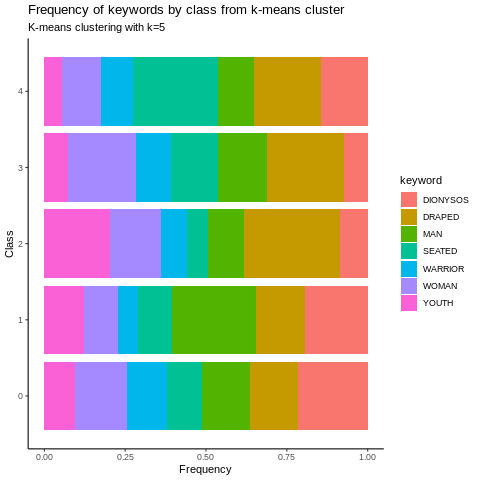

In [ ]:
%%R

(keywords_by_class_plot <- keywords_by_class_filtered %>%
  ggplot(data =., aes(x = Class, y = Freq, fill = keyword)) +
  geom_col(position = "fill") +
  # scale_fill_viridis_b() +
  # scale_fill_manual(values = c("black", "#E21936")) +
  coord_flip() +
  theme_classic() +
  # theme(legend.position = "none") +
  labs(title = "Frequency of keywords by class from k-means cluster",
       subtitle = "K-means clustering with k=5",
       x = "Class", y = "Frequency"))

The above plot does not indicate much separation by decoration, so below we inspect the words used to determine shape:

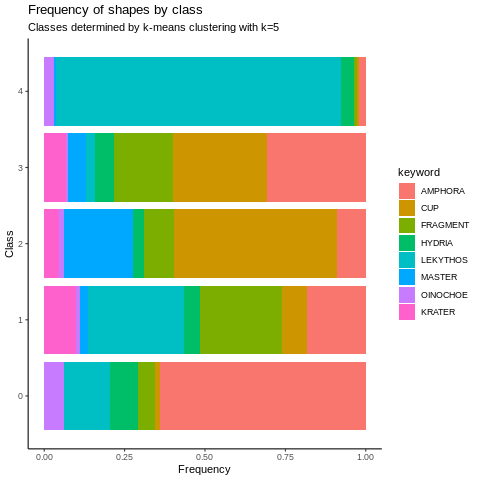

In [ ]:
%%R

(shapes_by_class_plot <- shapes_by_class %>%
  ggplot(data =., aes(x = Class, y = Freq, fill = keyword)) +
  geom_col(position = "fill") +
  # scale_fill_viridis_b() +
  # scale_fill_manual(values = c("black", "#E21936")) +
  coord_flip() +
  theme_classic() +
  # theme(legend.position = "none") +
  labs(title = "Frequency of shapes by class",
       subtitle = "Classes determined by k-means clustering with k=5",
       x = "Class", y = "Frequency"))

This plot indicates a clear delineation - class 4, for instance, is nearly entirely comprised of 'Lekythos' shaped vases. Similarly, we see that class 2 is largely comprised of 'Cup' shapes, and class 0 is mostly 'Amphora'. This lends empirical evidence to our fist impressions based on visual inspection of the model output in [the above sections](#layer-6-output). Because we very distinct classes when examining the shape-based metadata, we expect that saliency maps will reveal that our model is detecting edges very well.

In [ ]:
%%R

shapes_by_class_table <- shapes_by_class %>%
  group_by(Class) %>%
  mutate(Freq_sum = sum(Freq)) %>%
  mutate(Freq_pct = round(Freq / Freq_sum * 100), 3) %>%
  select(Class, keyword, Freq_pct) %>%
  pivot_wider(names_from = "keyword", values_from = "Freq_pct") %>%
  arrange(desc(Class)) %>%
  mutate(across(everything(), .fns = ~replace_na(.,0))) %>%
  as.data.frame() %>%
  mutate(across(everything(), .fns = function(x){paste0(as.character(x), "%")})) %>%
  mutate(Class = paste0("Class ", 4:0)) %>%
  print(row.names = FALSE)

shapes_by_class_table

   Class AMPHORA CUP FRAGMENT HYDRIA LEKYTHOS MASTER OINOCHOE KRATER
 Class 4      2%  1%       1%     4%      89%     1%       3%     0%
 Class 3     31% 29%      18%     6%       3%     6%       1%     7%
 Class 2      9% 51%       9%     4%       0%    21%       2%     5%
 Class 1     18%  8%      26%     5%      30%     2%       1%    10%
 Class 0     64%  2%       5%     9%      14%     0%       6%     0%


In [ ]:
###



# Model: Vanilla CNN - Stage 3

## Train vanilla CNN
We move forward with the feature representations extracted from layer 6 of convolutional autoencoder because the separation of clusters was much better than that for layer 10.

In [ ]:
from keras.utils import np_utils
from keras import regularizers
from keras.layers import BatchNormalization
from tensorflow.keras.optimizers import RMSprop

# we load classes = 5 from k-means = 6
nb_classes = 5

def create_cnn(input_shape=X_test.shape[1:], nb_classes=nb_classes,
               nb_blocks=3, nb_filters=32, filter_size=(3,3),
               pool_size=(2,2), weight_decay=1e-4, padding='same',
               dropout=.2, output_activation='softmax'):

    model = Sequential()

    for i in range(nb_blocks):
        if i==0:
            model.add(Conv2D(nb_filters, filter_size, activation='relu',
                             padding=padding,
                             input_shape=input_shape))
        else:
            model.add(Conv2D(nb_filters, filter_size, activation='relu',
                             padding=padding, kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(BatchNormalization())
        model.add(Conv2D(nb_filters, filter_size, activation='relu',
                  padding=padding, kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=pool_size))
        model.add(Dropout(dropout))

    model.add(Flatten())
    model.add(Dense(nb_classes, activation=output_activation))

    return model

cnn = create_cnn(nb_filters=32)
# compile CNN
opt_rms = RMSprop(learning_rate=0.001, decay=1e-6)
cnn.compile(loss='sparse_categorical_crossentropy', optimizer=opt_rms, metrics=['accuracy'])

#model training
history_cnn = cnn.fit(X_test,labels,epochs=5)

#save model history to dataframe
hist_cnn_df = pd.DataFrame(history_cnn.history)
# save model history dataframe to csv:
hist_cnn_csv_file = path+ 'vanilla_cnn_history.csv'
with open(hist_cnn_csv_file, mode='w') as f:
    hist_cnn_df.to_csv(f)

#save model to directory for later use
model_cnn_save_dir = path + 'vanilla_cnn_model.h5'
cnn.save(model_cnn_save_dir)

Epoch 1/5
71/71 [==============================] - 165s 2s/step - loss: 2.3572 - accuracy: 0.8833
Epoch 2/5
71/71 [==============================] - 169s 2s/step - loss: 0.9085 - accuracy: 0.9384
Epoch 3/5
71/71 [==============================] - 156s 2s/step - loss: 0.7155 - accuracy: 0.9555
Epoch 4/5
71/71 [==============================] - 143s 2s/step - loss: 0.4856 - accuracy: 0.9670
Epoch 5/5
71/71 [==============================] - 142s 2s/step - loss: 0.3302 - accuracy: 0.9749


## Results: Saliency maps

In [ ]:
# Generate saliency map with smoothing that reduce noise by adding noise
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.utils.scores import CategoricalScore
from tensorflow.keras.applications.vgg16 import preprocess_input
from matplotlib import cm
from tf_keras_vis.gradcam import Gradcam
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from matplotlib import pyplot as plt
from tf_keras_vis.activation_maximization import ActivationMaximization
from tf_keras_vis.activation_maximization.callbacks import Progress
from tf_keras_vis.activation_maximization.input_modifiers import Jitter, Rotate2D
from tf_keras_vis.activation_maximization.regularizers import TotalVariation2D, Norm
from tf_keras_vis.utils.model_modifiers import ExtractIntermediateLayer, ReplaceToLinear
from tf_keras_vis.utils.scores import CategoricalScore

def saliency_map(idx):
  y_test_preds = cnn.predict(X_test)
  X = np.array([X_test[idx]])
  score = CategoricalScore(np.argmax(y_test_preds[idx]))
  replace2linear = ReplaceToLinear()

  # Create Gradcam object
  gradcam = Gradcam(cnn,model_modifier=replace2linear,clone=True)

  # Smooth salience map
  saliency = Saliency(cnn,
                      model_modifier=replace2linear,
                      clone=True)

  saliency_map = saliency(score,
                          X,
                          smooth_samples=20, # The number of calculating gradients iterations.
                          smooth_noise=0.20)

  # Generate heatmap with GradCAM
  cam = gradcam(score,X,penultimate_layer=-1)
  f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
  f.suptitle("Saliency map for index {} | predicted {} | actual {}".format(idx,np.argmax(y_test_preds[idx]),labels[idx]))
  #original image
  ax[0].imshow(X[0], cmap='viridis', alpha=0.5)
  ax[0].set_title("Original Image");

  # smooth salienc map
  ax[1].imshow(X[0], cmap='viridis', alpha=0.5)
  ax[1].imshow(saliency_map[0], cmap='viridis', alpha=0.5)
  ax[1].set_title("SmoothGrad Saliency Map");

  # #gradcam
  ax[2].imshow(X[0], cmap='viridis', alpha=0.5)
  heatmap = np.uint8(cm.jet(cam[0])[..., :3] * 255)
  ax[2].imshow(heatmap, cmap='viridis', alpha=0.5)
  ax[2].set_title("GradCAM saliency heatmap")
  plt.show()
  ;


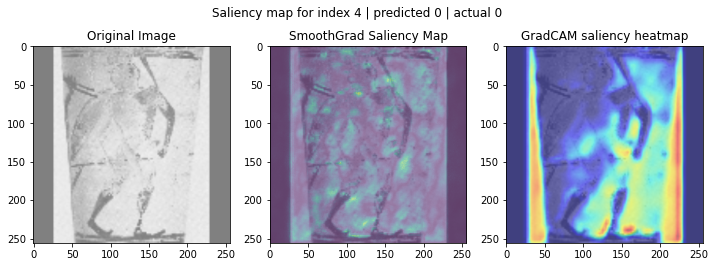

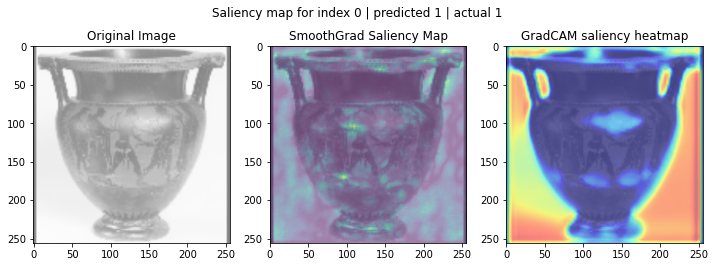

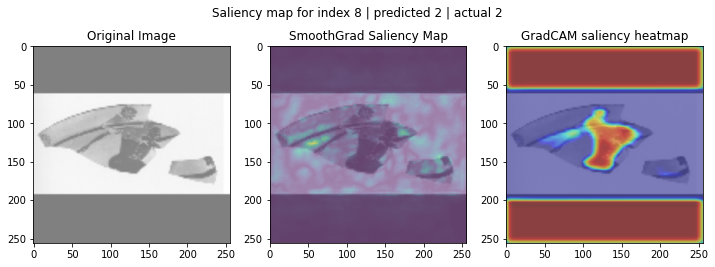

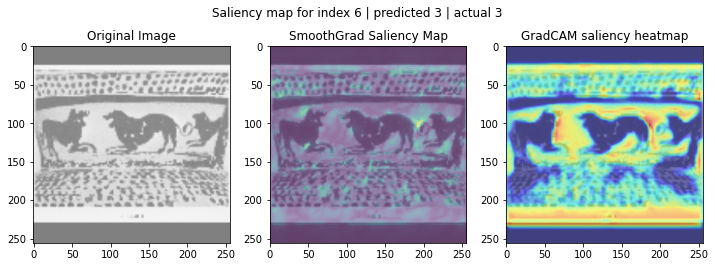

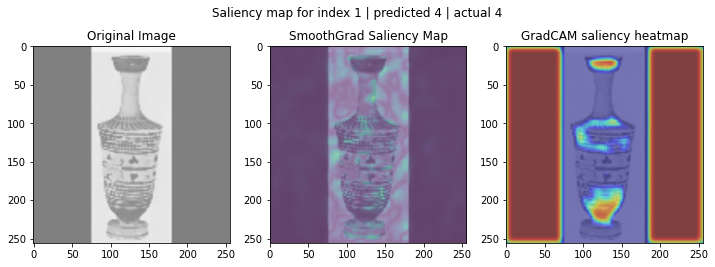

In [ ]:
#idx 4 = class 0
saliency_map(4)
#idx 0 = class 1
saliency_map(0)
#idx 8 = class 2
saliency_map(8)
#idx 6 = class 3
saliency_map(6)
#idx 1 = class 4
saliency_map(1)

* We can see from the saliency maps above that our vanilla CNN  focuses on the pixels around the vase for some of the classes, such as class 1 and class 3.   This may be the result of our training data includes images of whole vases instead of cropped versions of vases that highlight the scenes within vases.  This is a great MVP and and demonstrates the potential of adding cropped data augmentation that focuses on the scenes within the vase.

* We explored 2 different saliency map techniques:
  * SmoothGrad saliency map is unable to give us helpful information about which pixels are most activated. While SmoothGrad salienc maps make gradient-based explanations less noisy by adding noise and averaging over these artificially noisy gradients, the results do not help with interpretability.
  * GradCam gradient is backpropagated to the last convolutional layer to produce a coarse localization map that highlights important regions of the image.

* We can see that our CNN Model was able to predict our vases labels from the K-Means generated labels.
  * For class 0, our vanilla CNN uses the pixels on the bottom right to classify this as class 0.
  * For class 1, our vanilla CNN makes this prediction based on the pixel surroundings the vase and not the vase directlly.
  * For class 2, we can see that the model was able to focus on the human image on the vase fragement which reinforces our idea that we need to apply data augmentation for detailed focused segments of the vases that capture the vase visuals.
  * In class 3, we can see that the CNN model was able to also preserve the shape of the animals by labeling the space around it as important.
  * In class 4, the saliency map shows us that the vanilla CNN uses the pixel at the very top and the very bottom of the skinny, tall Greek vase to classify this image as class 4.

# Next steps / Limitations

* The model we trained focused only on black-figure vases. Future work could explore different types of vases (i.e. red-figure vases) or narrow the scope to focus on a particular type of vase (i.e. tall black vases).

* We were limited by memory and time. If we had more memory and time, we would run on the entirety of black-figure vases. We would also run each of our models -- the convolutional autoencoder and vanilla CNN -- with more epochs.

* Other work can explore the performance K-means as a function of different feature representations fed into from the convolutional autoencoder instead of just the two we examined (output of layer 6 and output at layer 10).

* We trained on images that featured the full vase, so our models was able to learn the general shape of vases (which are likely known by the meta data). We could focus more on scene detection if we instead cropped the images in such a way to isolate the scenes with humans or animals.

* Some intrinsic limitations exist, for example in the corpus of textual metadata in which different authors of descriptions use slightly different words and phrases to describe common occurrences. For example, "FRAGMENT" and "FRAGMENTS" were lised as two different categories, but in fact they could be collapsed to be the same category.

# References
1. “Arms and Armor | On Greek Vase-Painting.” Accessed May 6, 2022. https://armsandarmor.mused.org/en/.
2. Jin, Xin, and Jiawei Han. “K-Means Clustering.” In Encyclopedia of Machine Learning, edited by Claude Sammut and Geoffrey I. Webb, 563–64. Boston, MA: Springer US, 2010. https://doi.org/10.1007/978-0-387-30164-8_425.
3. Selvaraju, Ramprasaath R., Michael Cogswell, Abhishek Das, Ramakrishna Vedantam, Devi Parikh, and Dhruv Batra. “Grad-CAM: Visual Explanations from Deep Networks via Gradient-Based Localization.” In 2017 IEEE International Conference on Computer Vision (ICCV), 618–26, 2017. https://doi.org/10.1109/ICCV.2017.74.
4. Smilkov, Daniel, Nikhil Thorat, Been Kim, Fernanda Viégas, and Martin Wattenberg. “SmoothGrad: Removing Noise by Adding Noise.” ArXiv:1706.03825 [Cs, Stat], June 12, 2017. http://arxiv.org/abs/1706.03825.
5. Maggipinto, Marco, Chiara Masiero, Alessandro Beghi, and Gian Antonio Susto. “A Convolutional Autoencoder Approach for Feature Extraction in Virtual Metrology.” Procedia Manufacturing, 28th International Conference on Flexible Automation and Intelligent Manufacturing (FAIM2018), June 11-14, 2018, Columbus, OH, USAGlobal Integration of Intelligent Manufacturing and Smart Industry for Good of Humanity, 17 (January 1, 2018): 126–33. https://doi.org/10.1016/j.promfg.2018.10.023. https://www.sciencedirect.com/science/article/pii/S2351978918311399
6. Zhang, Yifei. “A Better Autoencoder for Image: Convolutional Autoencoder,” n.d., 7. http://users.cecs.anu.edu.au/~Tom.Gedeon/conf/ABCs2018/paper/ABCs2018_paper_58.pdf
7. Albawi, Saad, Tareq Abed Mohammed, and Saad Al-Zawi. “Understanding of a Convolutional Neural Network.” In 2017 International Conference on Engineering and Technology (ICET), 1–6, 2017. https://doi.org/10.1109/ICEngTechnol.2017.8308186.
8. Cai, T. Tony, and Rong Ma. “Theoretical Foundations of T-SNE for Visualizing High-Dimensional Clustered Data.” ArXiv:2105.07536 [Cs, Math, Stat], March 28, 2022. http://arxiv.org/abs/2105.07536.
